# American Sign Language - Computer Vision Project

- Dataset: https://public.roboflow.com/object-detection/american-sign-language-letters
- Example Task: https://towardsdatascience.com/sign-language-recognition-with-advanced-computer-vision-7b74f20f3442

In [1]:
# OVERRIDE_TESTING = False # Set to True to run tests even if not in testing mode

In [2]:
import numpy as np
import tensorflow as tf

# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical


tf.__version__

'2.12.0'

In [3]:
# Custom functions:
%load_ext autoreload
%autoreload 2
# sys.path.append(os.path.abspath("../../"))
import custom_functions as cf
help(cf)

Help on package custom_functions:

NAME
    custom_functions

PACKAGE CONTENTS
    ann_functions
    model_logging
    utils

SUBMODULES
    logs

FILE
    /Users/codingdojo/Documents/GitHub/_MY_PROJECTS/computer-vision-american-sign-language/custom_functions/__init__.py




In [4]:
import json, os
from pprint import pprint

# Define filename for project config filepaths json file
FPATHS_FILE = "config/filepaths.json"
os.makedirs(os.path.dirname(FPATHS_FILE), exist_ok=True)

# Define Filepaths
FPATHS = dict(
    data={
        # Images Directoryies
        'data_dir': "./American Sign Language Letters.v1-v1.multiclass/",
        "train-images_dir": "./American Sign Language Letters.v1-v1.multiclass/train/",
        "test-images_dir": "./American Sign Language Letters.v1-v1.multiclass/test/",
        
        # Image classes as csv fiels
        "train-labels_csv": "./American Sign Language Letters.v1-v1.multiclass/train/_classes.csv",
        "test-labels_csv": "./American Sign Language Letters.v1-v1.multiclass/test/_classes.csv",
        
        # Processed versions of the above csv files
        "train-labels_processed_csv": "./American Sign Language Letters.v1-v1.multiclass/train/_classes_processed.csv",
        "test-labels_processed_csv": "./American Sign Language Letters.v1-v1.multiclass/test/_classes_processed.csv",

        },

    images={
        "banner": "images/American_Sign_Language_ASL.svg",
        
    },
    # Any images to be displayed in the app
    eda={
        "label-distrubtion-countplot_png": "images/label-distribution-countplot.png",
        "test-labels-distrubtion_png": "images/test-label-distribution-countplot.png",
        "example-images_png": "images/ed_example_letters.png",
        "lime-explanation_png": "images/lime-explanation.png",
        "lime-explanation-wrong_png":"images/lime-explanation-wrong.png",
        "lime-explanation-right_png":"images/lime-explanation-right.png",
        
    },
    modeling={
        "model_dir": "modeling/models/",
            "results_log":"modeling/nn_training.log",
            "results_log_csv":"modeling/nn_training.csv",
            "train-dataset_dir": "modeling/data/training-data-tf/",  # train_ds
            "val-dataset_dir": "modeling/data/validation-data-tf/",  # train_ds
            "test-dataset_dir": "modeling/data/testing-data-tf/",  # test_ds
            "params":"modeling/params.json",
            "label-lookup_json": "modeling/label_lookup.json",
},
    # config = {'log_fpath': "logs/nn_training.log",},
    readme = {"results_table_md": "modeling/results_table.md",
             }
)


# Use fn for local package, ds for pip version
cf.utils.create_directories_from_paths(FPATHS)
# ds.utils.create_directories_from_paths(FPATHS)

print('[i] FPATHS Dictionary:\n')
pprint(FPATHS.keys())#, indent=4)

## Save the filepaths
with open(FPATHS_FILE, "w") as f:
    json.dump(FPATHS, f)
    print(f"\n[i] Saved FPATHS to {FPATHS_FILE}")
    
# FPATHS

[i] FPATHS Dictionary:

dict_keys(['data', 'images', 'eda', 'modeling', 'readme'])

[i] Saved FPATHS to config/filepaths.json


In [5]:
# pd.read_csv(FPATHS['modeling']['results_log_csv'])

### 🎛️ Project Params

In [6]:
## Set project-wide parameters
OVERWRITE_LOGS = True

# # Saving image params as vars for reuse
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128

## Set data split proportions
TRAIN_SPLIT = 0.7  # Proportion of data for training
VAL_SPLIT = 0.15  # Proportion of data for validation (remaining will be for test)


# Save model params
PATIENCE = 10  # For early stopping
EPOCHS = 100  # Max number of epochs to run
print(f"EPOCHS TEMPORARILY SET TO {EPOCHS}")

import json
## Save model params from above to json
params = {"BATCH_SIZE":BATCH_SIZE,
          "IMG_HEIGHT":IMG_HEIGHT,
          "IMG_WIDTH":IMG_WIDTH,
          "TRAIN_SPLIT":TRAIN_SPLIT,
          "VAL_SPLIT":VAL_SPLIT,
          "PATIENCE":PATIENCE,
          "EPOCHS":EPOCHS}

with open(FPATHS['modeling']['params'], "w") as f:
    json.dump(params, f)
    print(f"\n[i] Saved params to {FPATHS['modeling']['params']}")

EPOCHS TEMPORARILY SET TO 100

[i] Saved params to modeling/params.json


# Load Data

In [7]:
# Checking the contents of data folder
data_dir = FPATHS['data']['data_dir'] #"./American Sign Language Letters.v1-v1.multiclass/"
data_dir

'./American Sign Language Letters.v1-v1.multiclass/'

In [8]:
# Getting list of img file paths (ONLY, did not make recursuve so no folders)
img_files = glob.glob(data_dir+"**/*")#, recursive=True)
len(img_files)

1733

(416, 416, 3)


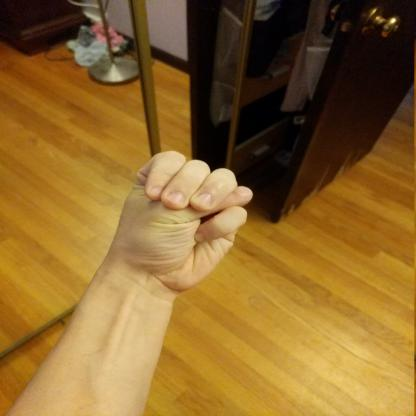

In [9]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
print(img_data.shape)
array_to_img(img_data)

### Prepare CSV of Filenames + Labels (1 per train/test)

In [10]:

# Load the CSV file
# csv_path = os.path.join(data_dir,"train","_classes.csv")
train_csv = FPATHS['data']['train-labels_csv']
df_train = pd.read_csv(train_csv)
df_train = df_train.convert_dtypes()
df_train = df_train.set_index('filename')
df_train = df_train.astype(float)
df_train

A    B    C    D    E    F  \
filename                                                                        
U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg   0.0  0.0  0.0  0.0  0.0  0.0   
P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg  0.0  0.0  0.0  0.0  0.0  0.0   
K4_jpg.rf.00821732715c9137b8060360770ea1d8.jpg   0.0  0.0  0.0  0.0  0.0  0.0   
W6_jpg.rf.00d19bc3a49f6469e2afa3aa92f14ff4.jpg   0.0  0.0  0.0  0.0  0.0  0.0   
J30_jpg.rf.00d20e595026b31773ded47509545471.jpg  0.0  0.0  0.0  0.0  0.0  0.0   
...                                              ...  ...  ...  ...  ...  ...   
A15_jpg.rf.ff648f0ba648df1d2782e75ddea0f9ba.jpg  1.0  0.0  0.0  0.0  0.0  0.0   
J3_jpg.rf.ff86dc5a870f1eadf471751c7fe11941.jpg   0.0  0.0  0.0  0.0  0.0  0.0   
A19_jpg.rf.ffe6b49b3b0683ef4eb235ec6c7eca9e.jpg  1.0  0.0  0.0  0.0  0.0  0.0   
S17_jpg.rf.fff4096dcee5716f16ea8e65ee5ef85d.jpg  0.0  0.0  0.0  0.0  0.0  0.0   
W20_jpg.rf.fffe2d54b2d00bbad942f6a406503d87.jpg  0.0  0.0  0.0  0.0  0.0  0.0   

                                                   G    H    I    J  ...    Q  \
filename                                                             ...        
U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg   0.0  0.0  0.0  0.0  ...  0.0   
P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg  0.0  0.0  0.0  0.0  ...  0.0   
K4_jpg.rf.00821732715c9137b8060360770ea1d8.jpg   0.0  0.0  0.0  0.0  ...  0.0   
W6_jpg.rf.00d19bc3a49f6469e2afa3aa92f14ff4.jpg   0.0  0.0  0.0  0.0  ...  0.0   
J30_jpg.rf.00d20e595026b31773ded47509545471.jpg  0.0  0.0  0.0  1.0  ...  0.0   
...                                              ...  ...  ...  ...  ...  ...   
A15_jpg.rf.ff648f0ba648df1d2782e75ddea0f9ba.jpg  0.0  0.0  0.0  0.0  ...  0.0   
J3_jpg.rf.ff86dc5a870f1eadf471751c7fe11941.jpg   0.0  0.0  0.0  1.0  ...  0.0   
A19_jpg.rf.ffe6b49b3b0683ef4eb235ec6c7eca9e.jpg  0.0  0.0  0.0  0.0  ...  0.0   
S17_jpg.rf.fff4096dcee5716f16ea8e65ee5ef85d.jpg  0.0  0.0  0.0  0.0  ...  0.0   
W20_jpg.rf.fffe2d54b2d00bbad942f6a406503d87.jpg  0.0  0.0  0.0  0.0  ...  0.0   

                                                   R    S    T    U    V    W  \
filename                                                                        
U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg   0.0  0.0  0.0  1.0  0.0  0.0   
P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg  0.0  0.0  0.0  0.0  0.0  0.0   
K4_jpg.rf.00821732715c9137b8060360770ea1d8.jpg   0.0  0.0  0.0  0.0  0.0  0.0   
W6_jpg.rf.00d19bc3a49f6469e2afa3aa92f14ff4.jpg   0.0  0.0  0.0  0.0  0.0  1.0   
J30_jpg.rf.00d20e595026b31773ded47509545471.jpg  0.0  0.0  0.0  0.0  0.0  0.0   
...                                              ...  ...  ...  ...  ...  ...   
A15_jpg.rf.ff648f0ba648df1d2782e75ddea0f9ba.jpg  0.0  0.0  0.0  0.0  0.0  0.0   
J3_jpg.rf.ff86dc5a870f1eadf471751c7fe11941.jpg   0.0  0.0  0.0  0.0  0.0  0.0   
A19_jpg.rf.ffe6b49b3b0683ef4eb235ec6c7eca9e.jpg  0.0  0.0  0.0  0.0  0.0  0.0   
S17_jpg.rf.fff4096dcee5716f16ea8e65ee5ef85d.jpg  0.0  1.0  0.0  0.0  0.0  0.0   
W20_jpg.rf.fffe2d54b2d00bbad942f6a406503d87.jpg  0.0  0.0  0.0  0.0  0.0  1.0   

                                                   X    Y    Z  
filename                                                        
U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg   0.0  0.0  0.0  
P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg  0.0  0.0  0.0  
K4_jpg.rf.00821732715c9137b8060360770ea1d8.jpg   0.0  0.0  0.0  
W6_jpg.rf.00d19bc3a49f6469e2afa3aa92f14ff4.jpg   0.0  0.0  0.0  
J30_jpg.rf.00d20e595026b31773ded47509545471.jpg  0.0  0.0  0.0  
...                                              ...  ...  ...  
A15_jpg.rf.ff648f0ba648df1d2782e75ddea0f9ba.jpg  0.0  0.0  0.0  
J3_jpg.rf.ff86dc5a870f1eadf471751c7fe11941.jpg   0.0  0.0  0.0  
A19_jpg.rf.ffe6b49b3b0683ef4eb235ec6c7eca9e.jpg  0.0  0.0  0.0  
S17_jpg.rf.fff4096dcee5716f16ea8e65ee5ef85d.jpg  0.0  0.0  0.0  
W20_jpg.rf.fffe2d54b2d00bbad942f6a406503d87.jpg  0.0  0.0  0.0  

[1512 rows x 26 columns]

In [11]:
# Saving list of one-hot-encoded labels
label_cols = classes = sorted(df_train.drop(columns=['filename','filepath','label'], errors='ignore').columns)
label_cols

[' A',
 ' B',
 ' C',
 ' D',
 ' E',
 ' F',
 ' G',
 ' H',
 ' I',
 ' J',
 ' K',
 ' L',
 ' M',
 ' N',
 ' O',
 ' P',
 ' Q',
 ' R',
 ' S',
 ' T',
 ' U',
 ' V',
 ' W',
 ' X',
 ' Y',
 ' Z']

In [12]:


# Combine label columns into single column
df_train.loc[:,'label'] = df_train[label_cols].apply(lambda x: x.idxmax(), axis=1)
display(df_train.head(2))

df_train['label'].value_counts(1).sort_index()

A    B    C    D    E    F  \
filename                                                                        
U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg   0.0  0.0  0.0  0.0  0.0  0.0   
P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg  0.0  0.0  0.0  0.0  0.0  0.0   

                                                   G    H    I    J  ...    R  \
filename                                                             ...        
U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg   0.0  0.0  0.0  0.0  ...  0.0   
P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg  0.0  0.0  0.0  0.0  ...  0.0   

                                                   S    T    U    V    W    X  \
filename                                                                        
U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg   0.0  0.0  1.0  0.0  0.0  0.0   
P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg  0.0  0.0  0.0  0.0  0.0  0.0   

                                                   Y    Z  label  
filename                                                          
U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg   0.0  0.0      U  
P12_jpg.rf.0046c1c30abbbccd31716c5b2ad835b9.jpg  0.0  0.0      P  

[2 rows x 27 columns]

label
A    0.045635
B    0.025794
C    0.035714
D    0.041667
E    0.041667
F    0.039683
G    0.039683
H    0.033730
I    0.051587
J    0.051587
K    0.033730
L    0.047619
M    0.033730
N    0.039683
O    0.035714
P    0.033730
Q    0.039683
R    0.031746
S    0.045635
T    0.027778
U    0.031746
V    0.037698
W    0.037698
X    0.041667
Y    0.031746
Z    0.043651
Name: proportion, dtype: float64

In [13]:
# Save prepend folder path to image filenames
train_img_dir = FPATHS['data']['train-images_dir']

# Save label lookup dictionary
label_lookup = {i:label for i,label in enumerate(classes)}
label_lookup

{0: ' A',
 1: ' B',
 2: ' C',
 3: ' D',
 4: ' E',
 5: ' F',
 6: ' G',
 7: ' H',
 8: ' I',
 9: ' J',
 10: ' K',
 11: ' L',
 12: ' M',
 13: ' N',
 14: ' O',
 15: ' P',
 16: ' Q',
 17: ' R',
 18: ' S',
 19: ' T',
 20: ' U',
 21: ' V',
 22: ' W',
 23: ' X',
 24: ' Y',
 25: ' Z'}

In [14]:
## Get the filepaths and labels
df_train = df_train.reset_index(drop=False)
df_train['filepath'] = df_train.loc[:,'filename'].astype(str).map(lambda x: os.path.join(train_img_dir, x)).values
filepaths = df_train['filepath']

labels = df_train[label_cols].astype(float).values
filepaths[0], labels[0]

('./American Sign Language Letters.v1-v1.multiclass/train/U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg',
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [15]:
def prepare_labels_df(csv_fpath, img_dir, return_label_lookup=False, 
                      save_processed_csv=False, processed_csv_fpath=None,
                      save_label_lookup=False, label_lookup_fpath=None):
    
    df = pd.read_csv(csv_fpath)
    
    df = df.convert_dtypes()
    
    # Save label columns
    label_cols = classes = sorted(df.drop(columns=['filename','filepath','label'], errors='ignore').columns)
    # df = df.set_index('filename')
    df[label_cols] = df[label_cols].astype(float)
    
    # Combine labels into single column for EDA
    df.loc[:,'label'] = df[label_cols].apply(lambda x: x.idxmax(), axis=1)
    
    # df = df.reset_index(drop=False)
    
    # Save prepend folder path to image filenames
    df['filepath'] = df.loc[:,'filename'].astype(str).map(lambda x: os.path.join(img_dir, x))
    
    
    if return_label_lookup | save_label_lookup:
        # Save label lookup dictionary
        label_lookup = {i:label for i,label in enumerate(classes)}
    
    if save_label_lookup:
        with open(label_lookup_fpath, "w") as f:
            json.dump(label_lookup, f)
            print(f"\n[i] Saved label lookup to {label_lookup_fpath}")

    
    if save_processed_csv:
        # Save processed csv
        df.to_csv(processed_csv_fpath, index=False)
        print(f"\n[i] Saved processed csv to {processed_csv_fpath}")
    
    if return_label_lookup:
        print("- DataFrame and label lookup dictionary returned.")
        return df, label_lookup
    
    else:
        print("- DataFrame only returned.")
        return df

In [16]:
# Load training data and labels
df_train, label_lookup = prepare_labels_df(FPATHS['data']['train-labels_csv'], 
                             FPATHS['data']['train-images_dir'], 
                             save_label_lookup=True, label_lookup_fpath=FPATHS['modeling']['label-lookup_json'],
                             save_processed_csv=True, processed_csv_fpath=FPATHS['data']['train-labels_processed_csv'],
                             return_label_lookup=True)
df_train.head(2)
label_lookup


[i] Saved label lookup to modeling/label_lookup.json

[i] Saved processed csv to ./American Sign Language Letters.v1-v1.multiclass/train/_classes_processed.csv
- DataFrame and label lookup dictionary returned.


{0: ' A',
 1: ' B',
 2: ' C',
 3: ' D',
 4: ' E',
 5: ' F',
 6: ' G',
 7: ' H',
 8: ' I',
 9: ' J',
 10: ' K',
 11: ' L',
 12: ' M',
 13: ' N',
 14: ' O',
 15: ' P',
 16: ' Q',
 17: ' R',
 18: ' S',
 19: ' T',
 20: ' U',
 21: ' V',
 22: ' W',
 23: ' X',
 24: ' Y',
 25: ' Z'}

In [17]:
# Load training data and labels
df_test = prepare_labels_df(FPATHS['data']['test-labels_csv'], 
                             FPATHS['data']['test-images_dir'], 
                             save_label_lookup=False, 
                             save_processed_csv=True, processed_csv_fpath=FPATHS['data']['test-labels_processed_csv'],
                             return_label_lookup=False)
display(df_test.head(2))


[i] Saved processed csv to ./American Sign Language Letters.v1-v1.multiclass/test/_classes_processed.csv
- DataFrame only returned.


filename    A    B    C    D    E  \
0  T24_jpg.rf.068e7b2424eac996c86bb6d9c38e083d.jpg  0.0  0.0  0.0  0.0  0.0   
1   Q7_jpg.rf.07fdf6c096cd2a9be72b4de4a627935d.jpg  0.0  0.0  0.0  0.0  0.0   

     F    G    H    I  ...    S    T    U    V    W    X    Y    Z  label  \
0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0      T   
1  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      Q   

                                            filepath  
0  ./American Sign Language Letters.v1-v1.multicl...  
1  ./American Sign Language Letters.v1-v1.multicl...  

[2 rows x 29 columns]

In [18]:
# Function to load and preprocess images for dataset
def load_image(filename, label, img_height=128, img_width=128):
    img = tf.io.read_file(filename)
    # img = tf.image.decode_image(img, channels=3)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])  # Explicitly set the shape
    img = tf.image.resize(img, [img_height, img_width])
    # img = img / 255.0  # Normalize the image
    return img, label

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB


[i] Preview Image (Training Data)
- Label (Category):  U
- Label (OHE): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0.]


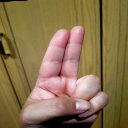

- Image Shape: (128, 128, 3)

[i] Preview Image (Testing Data)
- Label (Category):  T
- Label (OHE): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0.]


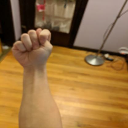

- Image Shape: (128, 128, 3)


In [19]:
# Dispay an example image
i = 0
# filepaths = df_train['filepath']
# labels = df_train[label_cols].astype(float).values

def preview_image(filepaths, labels, i, label_lookup, title=""):
    ex_img, ex_label = load_image(filepaths[i], labels[i])
    
    print("\n[i] Preview Image"+ title)
    print(f"- Label (Category): {label_lookup[np.argmax(ex_label)]}")
    print(f"- Label (OHE): {ex_label}")

    display(array_to_img(ex_img))
    print(f"- Image Shape: {ex_img.shape}")
    
    
    
# Preview an example from training and testing data
preview_image(filepaths=df_train['filepath'].values, labels=df_train[label_cols].values, i=0, label_lookup=label_lookup,
              title=" (Training Data)")

preview_image(filepaths=df_test['filepath'].values, labels=df_test[label_cols].values, i=0,label_lookup=label_lookup,
              title=" (Testing Data)")

### EDA

In [20]:
# eda_df = df_train[['filepath', 'label']]
# eda_df

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_25939/2816741415.py:10: UserWarning: The palette list has more values (26) than needed (24), which may not be intended.
  ax = sns.countplot(data=eda_df, x=x,order=classes,#label_lookup.values(),


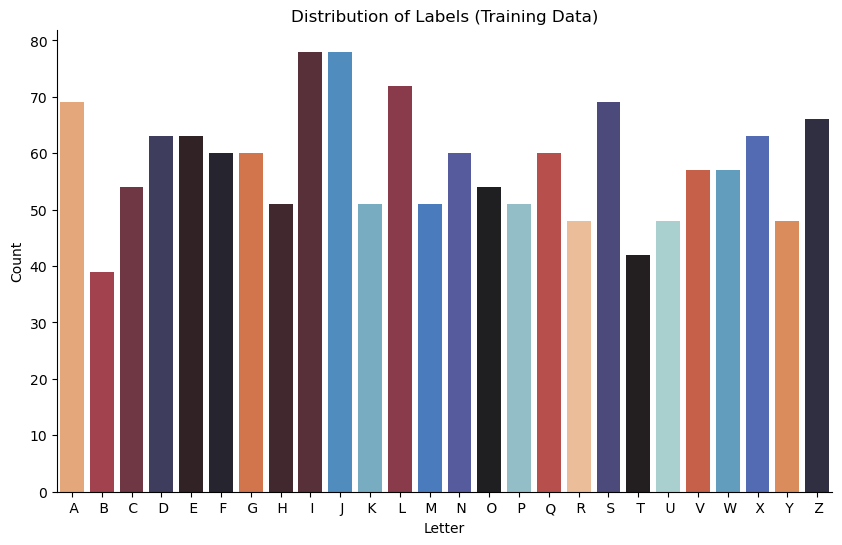

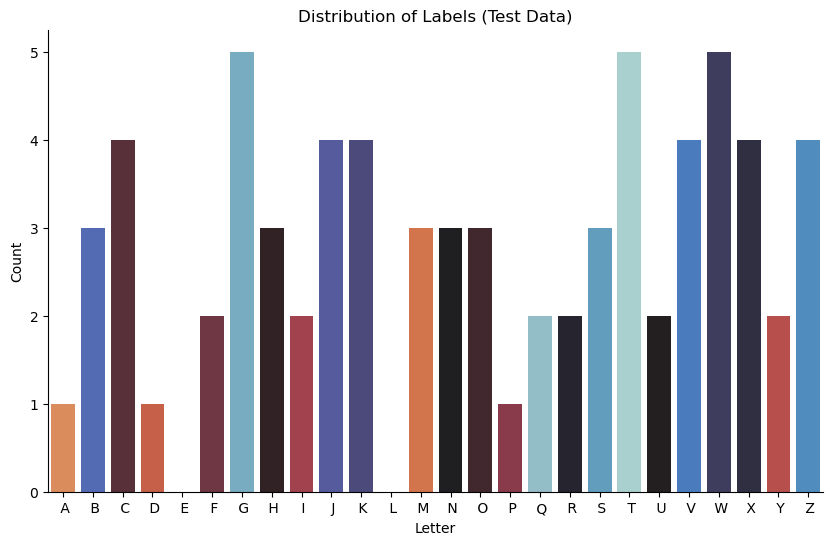

In [21]:
def plot_label_distribution(eda_df, x='label', title="Distribution of Labels (Training Data)", xlabel="Letter", ylabel="Count",
                            label_lookup=None, save_path=None):
    if label_lookup is None:
        classes = sorted(eda_df[x].unique())
    else:
        classes = sorted(label_lookup.values())
    
    # Plot Distrubtion of Labels in Training Data
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.countplot(data=eda_df, x=x,order=classes,#label_lookup.values(),
                hue=x, dodge=False,palette=sns.color_palette("icefire",n_colors=len(classes)),
                ax=ax)
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', transparent=False)
        
    return fig, ax
        
fig, ax = plot_label_distribution(df_train, title="Distribution of Labels (Training Data)", save_path=FPATHS['eda']['label-distrubtion-countplot_png'],
                                  label_lookup=label_lookup)
fig, ax = plot_label_distribution(df_test, title="Distribution of Labels (Test Data)", save_path=FPATHS['eda']['test-labels-distrubtion_png'],
                                  
                                  label_lookup=label_lookup)
# FPATHS['eda']['label-distrubtion-countplot_png']

#### Display Example of Each

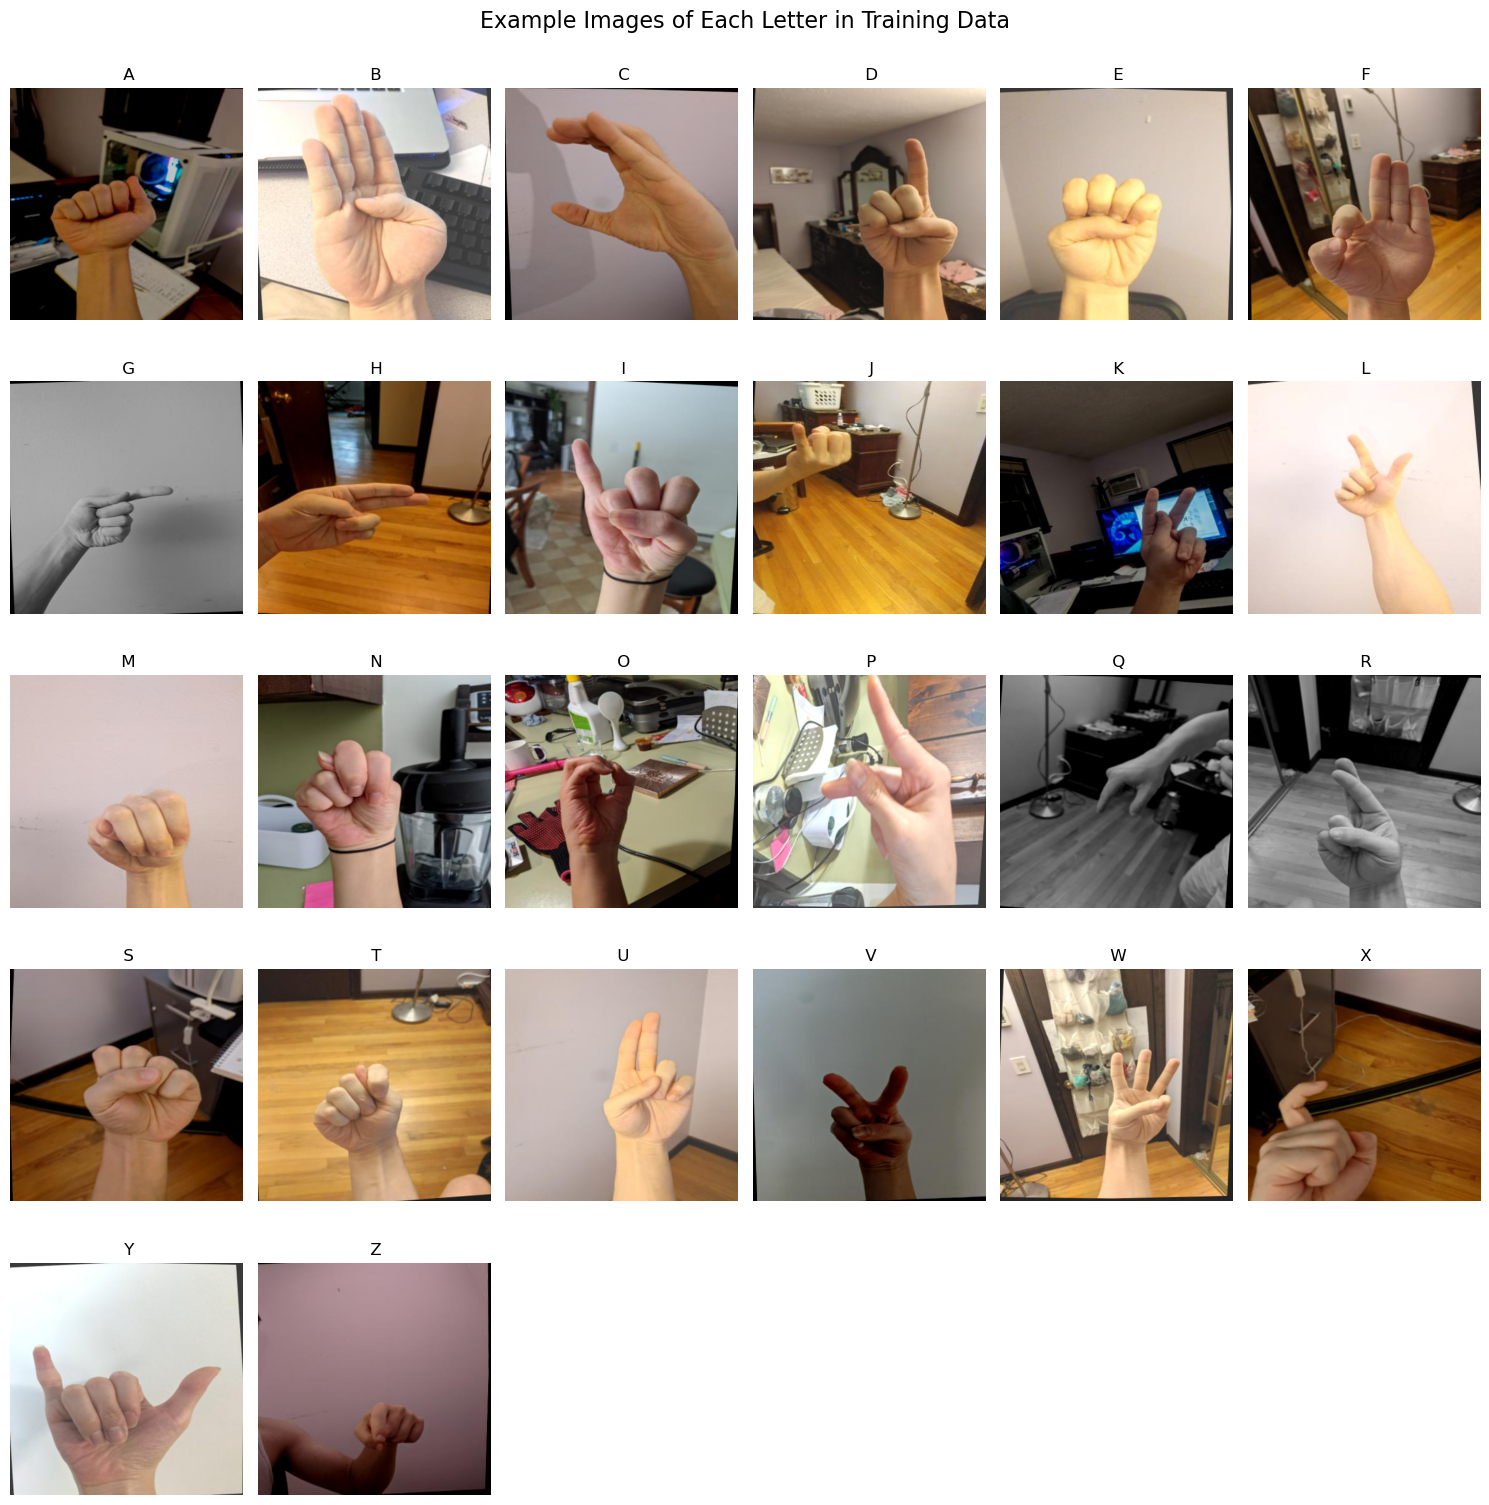

In [22]:
### Plot example of each letter
import os
# os.makedirs("images", exist_ok=True)

def plot_example_images(eda_df,label_col='label',fpath_col = "filepath", ncols = 6,figsize=(15,15),
                        save_path=None, suptitle=None, suptitle_y=1.02, suptitle_fontsize=16):
    # Save labels and determine rows
    unique_labels = sorted(eda_df[label_col].unique())
    nrows = len(unique_labels)//ncols + 1
    
    
    ## Create figure and flatten axes
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    axes = axes.flatten()
    
    # Plot example of each
    for i, label in enumerate(unique_labels):
        # Selet random example of label
        fpath = eda_df.loc[ eda_df[label_col]==label,fpath_col].sample(1).values[0]
        
        # Load and plot the iamge
        loaded = plt.imread(fpath)
        axes[i].imshow(loaded)
        axes[i].set_title(label)
        axes[i].axis('off')
        
    # Remove unused axes    
    axes_labels_diff =  len(axes) - len(unique_labels)
    if axes_labels_diff>0:
        for ax in axes[-axes_labels_diff:]:
            fig.delaxes(ax=ax)   
    
    # Tweak layout
    fig.tight_layout()
    if suptitle is not None:
        fig.suptitle(suptitle, y=suptitle_y, fontsize=suptitle_fontsize)
    
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', transparent=False)
        
    return fig, axes


fig, axes = plot_example_images(df_train, save_path=FPATHS['eda']['example-images_png'],
                                suptitle="Example Images of Each Letter in Training Data")

### Construct Train/Test/Val Tensorflow Datasets

In [23]:
len(df_train), len(df_test)

(1512, 72)

In [24]:
# load_image(image_paths[0], labels[0])

filepaths = df_train['filepath'].values
labels = df_train[label_cols].values
dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=False, seed=42)

dataset.take(1).get_single_element()

(<tf.Tensor: shape=(), dtype=string, numpy=b'./American Sign Language Letters.v1-v1.multiclass/train/Z5_jpg.rf.544842f2941835d4960bd18e6ef49bca.jpg'>,
 <tf.Tensor: shape=(26,), dtype=float64, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1.])>)

In [25]:
tf.data.experimental.AUTOTUNE

-1

In [26]:
## Map the load_image function to the dataseta
dataset = dataset.map(lambda x,y: load_image(x,y),
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset.take(1).get_single_element()

2024-06-03 16:56:16.119817: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[  3.3416748 ,   7.9247437 ,   4.0653687 ],
         [  6.633606  ,   9.110962  ,   5.970337  ],
         [  5.312256  ,   9.07135   ,   5.493225  ],
         ...,
         [  7.        ,   7.        ,   5.        ],
         [  4.        ,   8.        ,   7.        ],
         [  6.7890625 ,   7.0703125 ,   7.        ]],
 
        [[  9.078918  ,   3.024231  ,   1.913269  ],
         [  9.598511  ,   3.5438232 ,   0.96569824],
         [ 13.777283  ,   7.722595  ,   5.14447   ],
         ...,
         [  7.        ,   7.        ,   5.        ],
         [  4.        ,   8.        ,   7.        ],
         [  6.7890625 ,   7.0703125 ,   7.        ]],
 
        [[127.038025  , 107.68646   , 109.3349    ],
         [149.4851    , 130.13354   , 131.78198   ],
         [168.97876   , 149.6272    , 151.27563   ],
         ...,
         [  7.        ,   7.        ,   5.        ],
         [  4.        ,   8.        ,   7.      

In [27]:
# Determine split sizes
total_size = len(dataset)
train_size = int(TRAIN_SPLIT * total_size)
val_size = int(VAL_SPLIT * total_size)
test_size = total_size - train_size - val_size
print(f"{train_size=}, {test_size=}, {val_size=}")


train_size=1058, test_size=228, val_size=226


In [28]:
# Split the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Cache the datset for faster access
train_dataset = train_dataset.cache()
val_dataset = val_dataset.cache()
test_dataset = test_dataset.cache() 


In [29]:
# Batch and prefetch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Shuffle the trainin data
train_dataset = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), 
                                      reshuffle_each_iteration=True, 
                                      # seed=42
                                      )
                                    #   ) # DOUBLE CHECK BATCH_SIZE * 8


In [30]:

# Use the datasets
for images, labels in train_dataset.take(1):
    print(f"Train batch - images: {images.shape}, labels: {labels.shape}")
    
for images, labels in val_dataset.take(1):
    print(f"Val batch - images: {images.shape}, labels: {labels.shape}")
    
    
for images, labels in test_dataset.take(1):
    print(f"Test batch - images: {images.shape}, labels: {labels.shape}")
    

Train batch - images: (2, 128, 128, 3), labels: (2, 26)
Val batch - images: (32, 128, 128, 3), labels: (32, 26)


2024-06-03 16:56:16.676990: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Test batch - images: (32, 128, 128, 3), labels: (32, 26)


2024-06-03 16:56:16.912496: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Baseline Model (From towardsdatascience blog)
- from https://towardsdatascience.com/sign-language-recognition-with-advanced-computer-vision-7b74f20f3442


In [31]:
# Moedl from https://towardsdatascience.com/sign-language-recognition-with-advanced-computer-vision-7b74f20f3442
# from tensorflow
def make_model(name='towards-data-science',show_summary=False, use_schedule=False):
    model = models.Sequential(name=name)
    model.add(layers.Rescaling(1./255 , input_shape = (IMG_HEIGHT,IMG_WIDTH,3)))
    
    model.add(layers.Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' ))#, input_shape = (28,28,1)))
    
    model.add(layers.BatchNormalization())
    
    model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(layers.Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.BatchNormalization())
    
    model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(layers.Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    
    model.add(layers.BatchNormalization())
    
    model.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    # Final layers
    model.add(layers.Flatten())
    model.add(layers.Dense(units = 512 , activation = 'relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units = len(label_lookup   ) , activation = 'softmax'))
    
    
    ## JMI:
    if use_schedule:
        lr_schedule = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
        )  # 0.9)
        optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    else:
        optimizer = optimizers.legacy.Adam()#learning_rate=0.01)
        
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    # model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    if show_summary:
        model.summary()
    return model


# Demonstrate model architecture
model = make_model(show_summary=True)

Model: "towards-data-science"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 75)      2100      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 75)     300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 64, 64, 50

#### `def get_callbacks`

In [32]:


def get_callbacks(monitor='val_accuracy', patience=PATIENCE, #15,
                  start_from_epoch=3, restore_best_weights=False):
    """
    Returns a list of callbacks for training a model.

    Parameters:
    - monitor (str): The metric to monitor. Default is 'val_accuracy'.
    - patience (int): The number of epochs with no improvement after which training will be stopped. Default is 15.
    - start_from_epoch (int): The epoch from which to start counting the patience. Default is 3.
    - restore_best_weights (bool): Whether to restore the weights of the best epoch. Default is False.

    Returns:
    - callbacks (list): A list of callbacks to be used during model training.
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience,start_from_epoch=start_from_epoch,
                                                      monitor=monitor,
                                                      restore_best_weights=restore_best_weights, verbose=1)
    return [early_stopping]




### Define updated evaluation functions

> With 26 classes, it is difficult to scan the performance for each class visually. Adding code to convert results to a datafarme and use pandas styling to visualize

- added new `get_results_df` to custom_functions

###  New Custom Eval Function: 
- `custom_evaluate_classification_network` (for Notebook use only)

In [33]:
def custom_evaluate_classification_network(model, X_test, history=None, figsize=(15,15), target_names=None,
                                            #  as_frame=True, 
                                             frame_include_macro_avg=True, frame_include_support=False,
                                             display_bar=False, bar_subset_cols = ['recall','precision','f1-score'], 
                                             conf_matrix_text_kws={'fontsize': 'x-small'},
                                             return_figs= True, return_str_report=True):
    """
    Evaluate a classification model on a test dataset.

    Parameters:
    - model: The trained classification model.
    - X_test: The test dataset.
    - history: The training history of the model (optional).
    - figsize: The size of the figure for plotting the evaluation results (default: (15, 15)).
    - target_names: The names of the target classes (default: None).
    - as_frame: Whether to return the evaluation results as a pandas DataFrame (default: True).
    - frame_include_macro_avg: Whether to include macro average metrics in the DataFrame (default: False).
    - frame_include_support: Whether to include support values in the DataFrame (default: False).
    - display_bar: Whether to display the evaluation results as a styled bar chart (default: True).

    Returns:
    - results_dict: A dictionary containing the evaluation results.
    """
    if target_names is None:
        # label_lookup is in the global scope
        target_names = label_lookup.values()
        
    results_dict = cf.evaluate_classification_network(model,
                                                      X_test=X_test,history=history, figsize=figsize,
                                                # Set output to produce a dataframe (no option)
                                                  output_dict=True, as_frame=True,
                                                  target_names=target_names,
                                                  return_fig_conf_matrix=return_figs,
                                                  return_fig_history=return_figs,
                                                    frame_include_macro_avg=frame_include_macro_avg, 
                                                    frame_include_support=frame_include_support,
                                                    values_format=".2f",
                                                    conf_matrix_text_kws=conf_matrix_text_kws,
                                                    return_str_report=return_str_report)
    
    if isinstance(results_dict, tuple):
        results_dict, fig_dict = results_dict

        
        # if isinstance(results_dict, dict):
        #     class_results = results_dict['test']['results-classes']
        #     overall_results = results_dict['test']['results-overall']
        # else:
        #     class_results = results_dict['test']['results-classes']
        #     overall_results = None
        #     # print(results_dict)
    else:
        raise Exception("Results dict not a tuple")
    # elif isinstance(results_dict, dict):
    #     class_results = results_dict['test']['results-classes']
    #     overall_results = results_dict['test']['results-overall']:
        
    return_list = [results_dict]
    
    if display_bar:
        try:
            plot_data = results_dict['test']['results-classes']
            display(plot_data.style.bar(subset=bar_subset_cols, color='#5fba7d').format(formatter= lambda x: f"{x:.2f}").set_caption("Test Data"))
        except:
            display(results_dict)
        
    if return_figs:
        return results_dict, fig_dict
    return results_dict

> 📌BOOKMARK: Controlling Text Size on Confusion Matrix 

In [34]:
# # # TEST CODE (Must run modeling below first)
# results = custom_evaluate_classification_network(model,X_test=test_dataset, history=history, figsize=(15,15),
#                                                  target_names=label_lookup.values(),display_bar=True,);

## Model 1 (with New Function)

In [35]:
## Show model architecture
model = make_model(show_summary=True, use_schedule=False)

Model: "towards-data-science"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 75)      2100      
                                                                 
 batch_normalization_3 (Batc  (None, 128, 128, 75)     300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 75)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 50)        33800     
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 50

### Logging

In [36]:
log_file = FPATHS['modeling']['results_log']


In [37]:
import datetime as dt

dt.time.minute

<attribute 'minute' of 'datetime.time' objects>

In [38]:
# if record_inference_speed:
start_inference = dt.datetime.now()
preds = model.predict(test_dataset)
inference_time = dt.datetime.now() - start_inference
print(f"\nInference Speed: {inference_time.seconds:02d}.{inference_time.microseconds} seconds ({inference_time})")


8/8 [==============================] - 1s 30ms/step

Inference Speed: 00.639836 seconds (0:00:00.639836)


In [39]:
# Set up logging
import logging
import time
import datetime as dt

def initialize_logs(log_file = 'logs/nn_training.log', overwrite_logs=True,
                    log_header = ";start_time;name;fit_time;metrics;model_filepaths"):
    
    
    # #add deleting log file
    if overwrite_logs==True:
        filemode = "w"
        force=True
    else:
        filemode = 'a'
        force = False
        
    logging.basicConfig(filename=log_file, level=logging.INFO, filemode=filemode,force=force)#, format='%(message)s')
    logging.info(log_header)



# Function to log neural network details
def log_nn_details(start_time, name, fit_time, results_overall,model_filepaths=None ,
                   sep=";",**kwargs):
    # kwargs.update(locals())
    
    if model_filepaths is not None:
        fpaths_dict= model_filepaths
    else:
        fpaths_dict = "N/A"
        
    
    # Record results (except for filepaths)
    try:
        metrics = results_overall.loc['macro avg'].to_dict()
    except:
        metrics = results_overall

    info = f"{sep}{start_time.strftime('%m/%d/%Y %T')}{sep}{name}{sep}{fit_time}{sep}{metrics}{sep}{fpaths_dict}" 
    # info+= str(kwargs)
    
    # for key, value in kwargs.items():
        # info += f"{sep}{key}={value}"

        
    ## Log Info
    logging.info(info)
    
    

def fit_log_model(model, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, patience=PATIENCE,fit_kws= {}, callback_kws={}, 
                  save_results=True,record_inference_speed=True, model_directory='modeling/models/'):
    # Save start time
    
    start_time = dt.datetime.now()
    
    callbacks = get_callbacks(patience=patience, **callback_kws)
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, verbose=1,
                        callbacks=callbacks, **fit_kws)
    fit_time = dt.datetime.now() - start_time


    
    if record_inference_speed:
        start_inference = dt.datetime.now()
        preds = model.predict(test_dataset)
        inference_time = dt.datetime.now() - start_inference
        inference_datasize = len(test_dataset)
        print(f"\nInference Speed: {inference_time.seconds:02d}.{inference_time.microseconds:.3f} seconds ({inference_time}) for {inference_datasize} batches.")    
    
    # Evaluate the model
    results_frames, results_figs = custom_evaluate_classification_network(model,X_test=test_dataset, history=history, figsize=(15,15),
                                                 target_names=label_lookup.values(),display_bar=True,
                                                 frame_include_macro_avg=True, frame_include_support=False)

    if isinstance(results_frames, dict):
        class_results = results_frames['test']['results-classes']
        overall_results = results_frames['test']['results-overall']
        
        # TEMP
        # print(results_figs['test'])
        classification_report = results_figs['test']['classification_report']
    else:
        class_results = results_frames
        overall_results = None
        
    
    
    if overall_results is not None:
        print("\nOverall Results:")
        display(overall_results)
            
    model_results = dict(model=model, history=results_figs['history'],results_classes =class_results,
                results_overall= overall_results, 
                result_figs=results_figs,
                classification_report=classification_report
                )

    # Start saving log details
    log_info = dict(start_time=start_time,  name=model.name,
                    fit_time=fit_time,
                    inference_time=inference_time,
                    inference_size = inference_datasize,
                    results_overall=overall_results, 
                    model_filepaths=None)
        
    if save_results==True:
        model_filepaths = cf.logs.save_model_results( model_results, model_directory=model_directory,
                                             model_save_format="tf")
        log_info['model_filepaths'] = model_filepaths # dict(model_filepaths=model_filepaths)}
        
    log_nn_details(**log_info)#start_time, model.name, fit_time, overall_results)
        
    return model_results

    


In [40]:

# Iniialize Logs;
log_file = FPATHS['modeling']['results_log']
initialize_logs(log_file, overwrite_logs=True )#log_header = ";start_time;name;fit_time;metrics")


In [41]:



# def save_model_results(model_results, model_directory='modeling/models', model_save_format='tf'):
#     """
#     Saves the model, classification report, training history, and confusion matrix to specified directory.
    
#     Parameters:
#         filepath (str): Base name for the files to be saved.
#         model_directory (str): Directory where files will be saved.
#         model_results (dict): Dictionary containing model, history, and metrics.
#         model_save_format (str): Format to save the model, default is 'tf'.
    
#     Returns:
#         dict: Dictionary containing paths to the saved files.
        
        
#     # Example Usage:
#     # model_results = {
#     #     'model': tf.keras.models.Sequential([...]),  # Your trained model
#     #     'history': plt.figure(),  # A matplotlib figure of your training history
#     #     'result_figs': {
#     #         'test': {
#     #             'classification_report': "Your classification report text",
#     #             'confusion_matrix': plt.figure()  # A matplotlib figure of your confusion matrix
#     #         }
#     #     }
#     # }
#     # filepaths = save_model_results(', 'model_directory', model_results)
#     """
#     import os
#     import tensorflow as tf
#     import matplotlib.pyplot as plt
#     import warnings
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")

#     os.makedirs(model_directory, exist_ok=True)
#     # Use model.name as the base name for the files
#     model = model_results['model']
    
#     model_directory = os.path.join(model_directory, model.name)
#     # model_fpath = os.path.join(model_directory,f"{model.name}")
    

#     # Generate file paths
#     if model_save_format == 'tf':
#         model_save_fpath = model_directory#os.path.join(model_directory,f"{model.name}/")
#     else:
#         model_save_fpath = os.path.join(model_directory, f"model.{model_save_format}")
        
#     # Ensure the model directory exists
#     if os.path.isdir(model_save_fpath)==True:
#         os.makedirs(model_save_fpath, exist_ok=True)
#     else:
#         os.makedirs(os.path.dirname(model_save_fpath), exist_ok=True)

#     save_classification_report_fpath = os.path.join(model_directory, "classification_report.txt")
#     save_history_fpath = os.path.join(model_directory, f"history.png")
#     save_confusion_matrix_fpath = os.path.join(model_directory, "confusion_matrix.png")
    
#     # Save model
#     try:
#         tf.keras.models.save(model_results['model'],model_save_fpath, save_format=model_save_format) 
#         # model_results['model'].save(model_save_fpath, save_format=model_save_format)
#         print(f"- Model saved to {model_save_fpath}")
#     except Exception as e:
#         print(f"[!] Error saving model: {e}")

#     # Save classification report
#     try:
#         report_str = model_results['classification_report']
#         with open(save_classification_report_fpath, "w") as f:
#             f.write(report_str)
#         print(f"- Classification Report saved to {save_classification_report_fpath}")
#     except Exception as e:
#         display(f"[!] Error saving classification report: {e}")

#     # Save training history
#     try:
#         history_fig = model_results['history']
#         history_fig.savefig(save_history_fpath, dpi=300, bbox_inches='tight', transparent=False)
#         print(f"- History figure saved to {save_history_fpath}")
#     except Exception as e:
#         display(f"[!] Error saving history figure: {e}")
#     # Save confusion matrix
#     try:
#         confusion_matrix_fig = model_results['result_figs']['test']['confusion_matrix']
#         confusion_matrix_fig.savefig(save_confusion_matrix_fpath, dpi=300, bbox_inches='tight', transparent=False)
#         print(f"- Confusion Matrix figure saved to {save_confusion_matrix_fpath}")
#     except Exception as e:
#         display(f"[!] Error saving confusion matrix figure: {e}")

#     return {
#         "model_save_fpath": model_save_fpath, 
#         "save_classification_report_fpath": save_classification_report_fpath,
#         "save_history_fpath": save_history_fpath, 
#         "save_confusion_matrix_fpath": save_confusion_matrix_fpath
#     }





Epoch 1/100
34/34 [==============================] - 4s 102ms/step - loss: 5.4981 - accuracy: 0.0955 - val_loss: 3.5683 - val_accuracy: 0.0442
Epoch 2/100
34/34 [==============================] - 3s 76ms/step - loss: 2.4941 - accuracy: 0.3526 - val_loss: 5.0937 - val_accuracy: 0.0398
Epoch 3/100
34/34 [==============================] - 3s 74ms/step - loss: 1.2030 - accuracy: 0.6749 - val_loss: 7.9364 - val_accuracy: 0.0442
Epoch 4/100
34/34 [==============================] - 3s 75ms/step - loss: 0.3891 - accuracy: 0.8932 - val_loss: 7.5747 - val_accuracy: 0.0487
Epoch 5/100
34/34 [==============================] - 3s 74ms/step - loss: 0.1050 - accuracy: 0.9735 - val_loss: 10.3509 - val_accuracy: 0.0442
Epoch 6/100
34/34 [==============================] - 3s 74ms/step - loss: 0.0486 - accuracy: 0.9877 - val_loss: 8.7621 - val_accuracy: 0.0487
Epoch 7/100
34/34 [==============================] - 3s 75ms/step - loss: 0.0492 - accuracy: 0.9858 - val_loss: 9.9064 - val_accuracy: 0.0442
Epoc

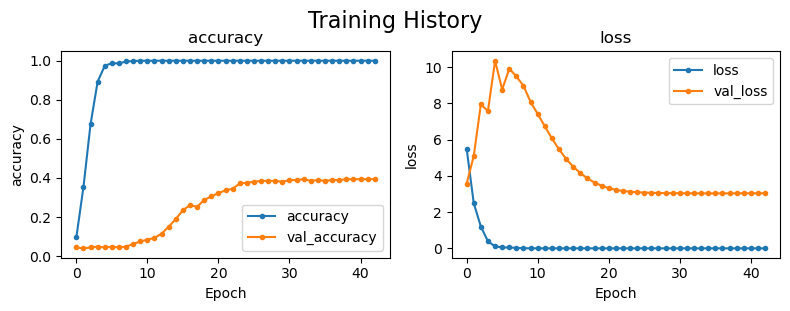


- Evaluating Test Data:
8/8 [==============================] - 0s 48ms/step - loss: 3.1389 - accuracy: 0.3904
{'loss': 3.138899803161621, 'accuracy': 0.390350878238678} 

--------------------------------------------------------------------------------
 Classification Metrics: Test Data 
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           A       0.06      0.14      0.09         7
           B       1.00      0.20      0.33         5
           C       0.33      0.25      0.29         8
           D       0.50      0.50      0.50        12
           E       0.17      0.33      0.22         6
           F       0.00      0.00      0.00         7
           G       0.62      0.50      0.56        10
           H       0.40      0.80      0.53         5
           I       0.43      0.67      0.52         9
           J       0.58      0.69      0.63        16
           K       0.50      0.29  

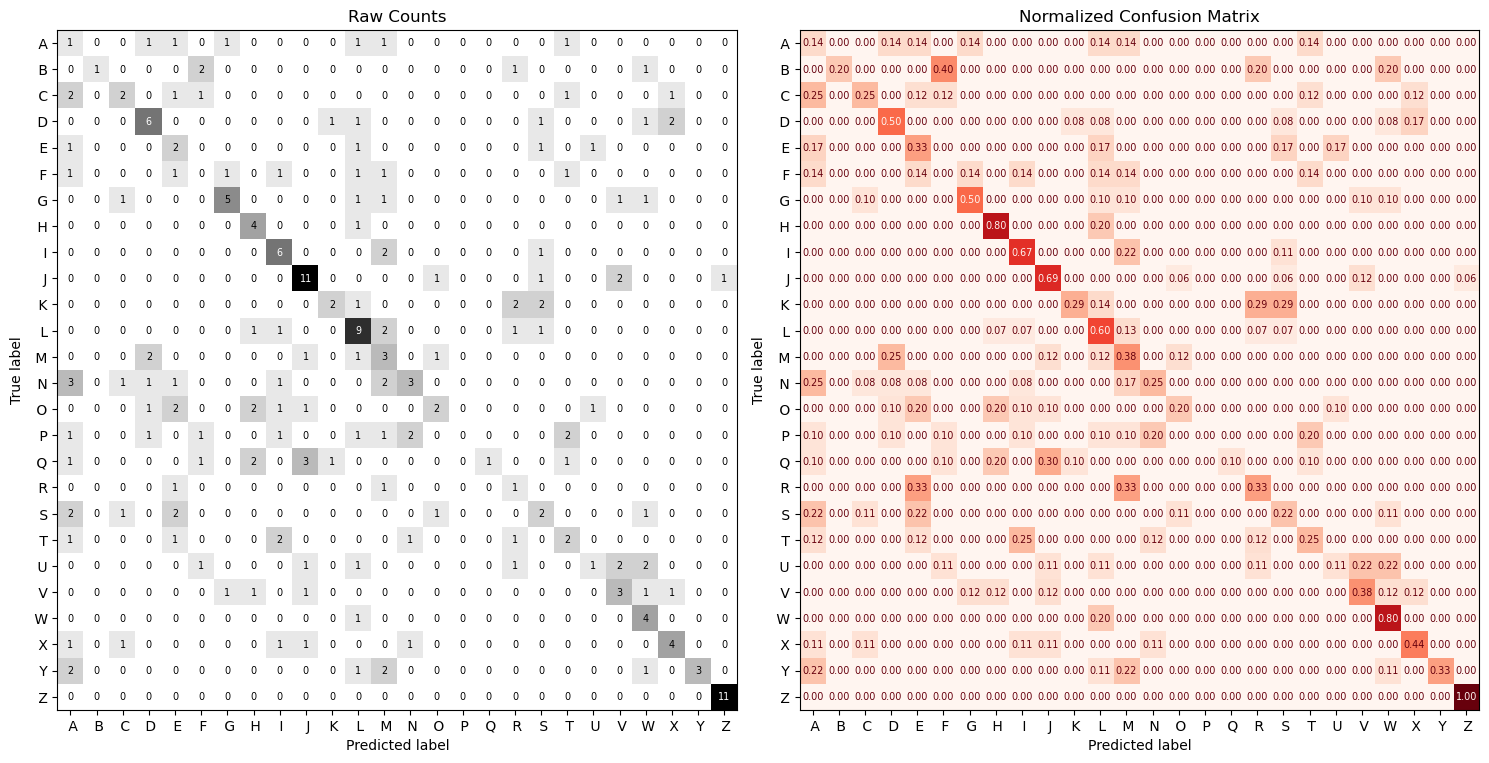


Overall Results:


precision    recall  f1-score  support  accuracy
macro avg   0.427426  0.375404  0.352189    228.0  0.390351

INFO:tensorflow:Assets written to: modeling/models/towards-data-science/assets
- Model saved to modeling/models/towards-data-science
- Classification Report saved to modeling/models/towards-data-science/classification_report.txt
- History figure saved to modeling/models/towards-data-science/history.png
- Confusion Matrix figure saved to modeling/models/towards-data-science/confusion_matrix.png

CPU times: user 38.3 s, sys: 12.1 s, total: 50.3 s
Wall time: 1min 58s


In [42]:
%%time
# TEMP COMMENTED OUT
# Baseline model
model_dir = FPATHS['modeling']['model_dir']
model = make_model(show_summary=False, use_schedule=False)
model_results = fit_log_model(model, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, patience=PATIENCE,
                              save_results=True,model_directory=model_dir)
print()


### Bookmark: 06/01 - Parsing and Displaying/Saving DataFrame Logs

In [43]:
FPATHS['modeling']['results_log']

'modeling/nn_training.log'

In [44]:
# def parse_log_file(log_file, sep=';', keep_only_startswith=['info:root'], clean_results=True,
#                    save_csv=True, save_fpath=FPATHS['modeling']['results_log_csv']):
#     """
#     Parses a log file and returns a pandas DataFrame containing the log data.

#     Parameters:
#     - log_file (str): The path to the log file.
#     - sep (str): The separator used to split the log lines into columns. Default is ';'.
#     - keep_only (str): The prefix of the lines to keep in the log file. Default is 'info:root'.

#     Returns:
#     - logs_df (pandas DataFrame): The parsed log data as a DataFrame.

#     """
#     if (save_fpath is None) and (save_csv==True):
#         save_fpath = log_file.replace('.log', '.csv')
#     import ast
#     import pandas as pd
    
#     # Read logs
#     with open(log_file, 'r') as file:
#         log_lines = file.readlines()
#         file.seek(0)
        
#     # Remove unwanted lines
#     split_lines = []
#     for line in log_lines:
#         compare_line = line.strip().lower()
#         for keep_only in keep_only_startswith:
#             if compare_line.startswith(keep_only.lower()):
#                 split_lines.append(line.strip().strip(sep).split(sep))
#                 # break
            
#         # if line.strip().lower().startswith(keep_only):
#         #     split_lines.append(line.strip().split(sep))

#     # Create DataFrame
#     # try:
#     logs_df = pd.DataFrame(split_lines[1:], columns=split_lines[0])
#     # ?except Exception as e:
#     #     display(e)
#     #     # display(split_lines[0])
#     #     logs_df = pd.DataFrame(split_lines)
#     #     display(logs_df)
#     # Fill NaN values and convert metrics column to dictionary
#     logs_df = logs_df.fillna("{}")
#     logs_df['metrics'] = logs_df['metrics'].map(lambda x: ast.literal_eval(x))
#     metrics_df = pd.json_normalize(logs_df['metrics'])
    
#     ## Concatenate metrics columns to main dataframe
#     logs_df = pd.concat([logs_df.drop(columns=['metrics']), metrics_df], axis=1)

#     # If model_filepaths column exists, convert to dictionary and normalize
#     if 'model_filepaths' in logs_df.columns:
#         logs_df['model_filepaths'] = logs_df['model_filepaths'].map(lambda x: ast.literal_eval(x))
#         fpaths_df = pd.json_normalize(logs_df['model_filepaths'])
        
        
#         logs_df = pd.concat([logs_df.drop(columns='model_filepaths'), fpaths_df], axis=1)
    
    
#     if save_csv and not clean_results:
#         logs_df.to_csv(save_fpath, index=False)
#         print(f"\n[i] Saved parsed logs to {save_fpath}")
    
#     if clean_results:
#         first_col = logs_df.columns[0]
#         drop_cols = ['support']

#         drop_cols.extend([f for f in logs_df.drop(columns="model_save_fpath").columns if 'fpath' in f])
#         if first_col.lower().startswith("info:root"):
#             drop_cols.append(first_col)
#         logs_df = logs_df.drop(columns=drop_cols)# errors='ignore')
        
#         logs_df = logs_df.round(3)
#         ## rearrange columns
#         move_to_end = ['fit_time','model_save_fpath']
#         logs_df = logs_df[ logs_df.drop(columns=move_to_end).columns.tolist()+move_to_end]
#         # Make titled columns
#         logs_df.columns=[c.replace("_"," ").title() for c in logs_df.columns]
        
#         if save_csv:
#             logs_df.to_csv(save_fpath, index=False)
#             print(f"\n[i] Saved parsed logs to {save_fpath}")
            
    

#     return logs_df

In [45]:
help(cf.logs.parse_log_file)

Help on function parse_log_file in module custom_functions.model_logging:

parse_log_file(log_file, sep=';', keep_only_startswith=['info:root'], clean_results=True, remove_fpaths=True, save_csv=True, save_fpath=None)
    Parses a log file and returns a pandas DataFrame containing the log data.
    
    Parameters:
    - log_file (str): The path to the log file.
    - sep (str): The separator used to split the log lines into columns. Default is ';'.
    - keep_only (str): The prefix of the lines to keep in the log file. Default is 'info:root'.
    
    Returns:
    - logs_df (pandas DataFrame): The parsed log data as a DataFrame.



In [46]:
logs_df = cf.logs.parse_log_file(log_file)
logs_df


[i] Saved parsed logs to modeling/nn_training.csv


Start Time                  Name  Precision  Recall  F1-Score  \
0  06/03/2024 16:56:18  towards-data-science      0.427   0.375     0.352   

   Accuracy        Fit Time                      Model Save Fpath  
0      0.39  0:01:51.209080  modeling/models/towards-data-science

In [47]:
# with open(log_file) as f:#FPATHS['modeling']['results_log']) as f:
#     # log_lines = f.readlines()
# log_lines

In [48]:
FPATHS['modeling']['results_log'], log_file

('modeling/nn_training.log', 'modeling/nn_training.log')

In [49]:
# log_lines[1].strip().strip(';').split(";")

In [50]:
logs_df = cf.logs.parse_log_file(log_file,clean_results=True      )
logs_df


[i] Saved parsed logs to modeling/nn_training.csv


Start Time                  Name  Precision  Recall  F1-Score  \
0  06/03/2024 16:56:18  towards-data-science      0.427   0.375     0.352   

   Accuracy        Fit Time                      Model Save Fpath  
0      0.39  0:01:51.209080  modeling/models/towards-data-science

In [51]:
# logs_df = parse_log_file(log_file, clean_result=True, save_csv=True, save_fpath=FPATHS['modeling']['results_log_csv'])
# logs_df

In [52]:
def load_model_results(model_name, model_directory='modeling/models/',
                       load_model=True, figs_as_matplotlib=True):
    """
    Loads the model, classification report, training history, and confusion matrix from the specified directory.
    
    Parameters:
        model_name (str): Base name for the files to be loaded.
        model_directory (str): Directory where files are saved.
    
    Returns:
        dict: Dictionary containing the loaded files.
    """
    import os
    import tensorflow as tf
    import matplotlib.pyplot as plt
    from tensorflow.keras.utils import load_img, img_to_array, array_to_img
    
    # Load model
    model_fpath = os.path.join(model_directory, model_name)

    
    # Load classification report
    classification_report_fpath = os.path.join(model_fpath, "classification_report.txt")
    with open(classification_report_fpath, "r") as f:
        classification_report = f.read()
    
    # Load training history
    history_fpath = os.path.join(model_fpath, f"history.png")
    
    if figs_as_matplotlib:
        history_fig,ax  = plt.subplots()
        ax.imshow(plt.imread(history_fpath))
        ax.axis('off')

    else:
        history_fig = load_img(history_fpath)
    # history_fig = plt.imread(history_fpath)
    
    # Load confusion matrix
    confusion_matrix_fpath = os.path.join(model_fpath, "confusion_matrix.png")
    
    if figs_as_matplotlib:
        confusion_matrix_fig, ax  = plt.subplots()
        ax.imshow(plt.imread(confusion_matrix_fpath))
        ax.axis('off')

        
    else:
        confusion_matrix_fig = load_img(confusion_matrix_fpath)
    
    loaded =  {
        "classification_report": classification_report,
        "history_fig": history_fig,
        "confusion_matrix_fig": confusion_matrix_fig
    }
    if load_model:
        model = tf.keras.models.load_model(model_fpath)
    
    loaded['model'] = model
    return loaded

loaded = load_model_results(model_name=logs_df.loc[0,'Name'], model_directory= FPATHS['modeling']['model_dir'],
                            load_model=True)
print(loaded.keys())
loaded['model'].summary()


In [53]:
# loaded['history_fig']

In [54]:
# plt.imshow(loaded['history_fig'])

In [55]:
# print(loaded['classification_report'])
# display(loaded['history_fig'])
# display(loaded['confusion_matrix_fig'])



In [56]:
# loaded['model']

In [57]:
# loaded['model'
#        ].predict(test_dataset)

### ✅ To Do:
- Define a save_results function to use the filepaths in FPATHS to save the results dict

In [58]:
# # pd.read_csv()
# def load_model_results(model_name, model_directory='modeling/models/',
#                        load_model=True, figs_as_matplotlib=True):
#     """
#     Loads the model, classification report, training history, and confusion matrix from the specified directory.
    
#     Parameters:
#         model_name (str): Base name for the files to be loaded.
#         model_directory (str): Directory where files are saved.
    
#     Returns:
#         dict: Dictionary containing the loaded files.
#     """
#     import os
#     import tensorflow as tf
#     import matplotlib.pyplot as plt
#     from tensorflow.keras.utils import load_img, img_to_array, array_to_img
    
#     # Load model
#     model_fpath = os.path.join(model_directory, model_name)

    
#     # Load classification report
#     classification_report_fpath = os.path.join(model_fpath, "classification_report.txt")
#     with open(classification_report_fpath, "r") as f:
#         classification_report = f.read()
    
#     # Load training history
#     history_fpath = os.path.join(model_fpath, f"history.png")
    
#     if figs_as_matplotlib:
#         history_fig,ax  = plt.subplots()
#         ax.imshow(plt.imread(history_fpath))
#         ax.axis('off')

#     else:
#         history_fig = load_img(history_fpath)
#     # history_fig = plt.imread(history_fpath)
    
#     # Load confusion matrix
#     confusion_matrix_fpath = os.path.join(model_fpath, "confusion_matrix.png")
    
#     if figs_as_matplotlib:
#         confusion_matrix_fig, ax  = plt.subplots()
#         ax.imshow(plt.imread(confusion_matrix_fpath))
#         ax.axis('off')

        
#     else:
#         confusion_matrix_fig = load_img(confusion_matrix_fpath)
    
#     loaded =  {
#         "classification_report": classification_report,
#         "history_fig": history_fig,
#         "confusion_matrix_fig": confusion_matrix_fig
#     }
#     if load_model:
#         model = tf.keras.models.load_model(model_fpath)
    
#     loaded['model'] = model
#     return loaded
help(cf.logs.load_model_results)

Help on function load_model_results in module custom_functions.model_logging:

load_model_results(model_name, model_directory='modeling/models/', load_model=True, figs_as_matplotlib=True)
    Loads the model, classification report, training history, and confusion matrix from the specified directory.
    
    Parameters:
        model_name (str): Base name for the files to be loaded.
        model_directory (str): Directory where files are saved.
    
    Returns:
        dict: Dictionary containing the loaded files.




[i] Saved parsed logs to modeling/nn_training.csv
dict_keys(['classification_report', 'history_fig', 'confusion_matrix_fig', 'model'])
Model: "towards-data-science"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 75)      2100      
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 75)     300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 75)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64

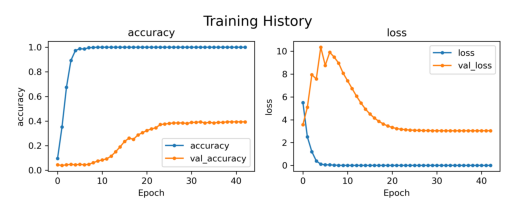

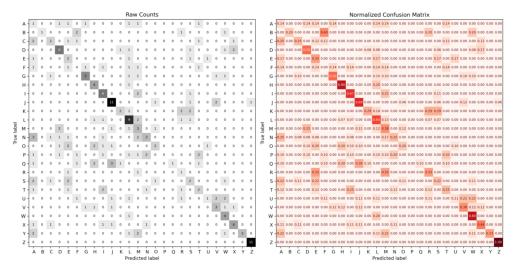

In [59]:

logs_df = cf.logs.parse_log_file(log_file,clean_results=True      )

loaded = cf.logs.load_model_results(model_name=logs_df.loc[0,'Name'], model_directory= FPATHS['modeling']['model_dir'],
                            load_model=True)
print(loaded.keys())
loaded['model'].summary()


In [60]:
# loaded['model'].predict(test_dataset)

In [61]:
del model, loaded

In [62]:
# # save datasets
# train_dataset.save(FPATHS['modeling']['train-dataset_dir'])
# test_dataset.save(FPATHS['modeling']['test-dataset_dir'])
# val_dataset.save(FPATHS['modeling']['val-dataset_dir'])

### Model 1-LR: Adding LR Scheduling to Model 1

Epoch 1/100
34/34 [==============================] - 4s 87ms/step - loss: 24.8561 - accuracy: 0.0652 - val_loss: 97.8268 - val_accuracy: 0.0354
Epoch 2/100
34/34 [==============================] - 3s 75ms/step - loss: 3.3652 - accuracy: 0.0775 - val_loss: 66.6040 - val_accuracy: 0.0398
Epoch 3/100
34/34 [==============================] - 3s 75ms/step - loss: 3.0950 - accuracy: 0.0992 - val_loss: 43.8442 - val_accuracy: 0.0354
Epoch 4/100
34/34 [==============================] - 2s 73ms/step - loss: 3.0268 - accuracy: 0.1163 - val_loss: 38.2122 - val_accuracy: 0.0265
Epoch 5/100
34/34 [==============================] - 3s 74ms/step - loss: 3.0322 - accuracy: 0.1295 - val_loss: 37.3666 - val_accuracy: 0.0221
Epoch 6/100
34/34 [==============================] - 2s 73ms/step - loss: 2.9890 - accuracy: 0.1314 - val_loss: 32.2320 - val_accuracy: 0.0221
Epoch 7/100
34/34 [==============================] - 3s 74ms/step - loss: 2.9393 - accuracy: 0.1418 - val_loss: 25.7959 - val_accuracy: 0.022

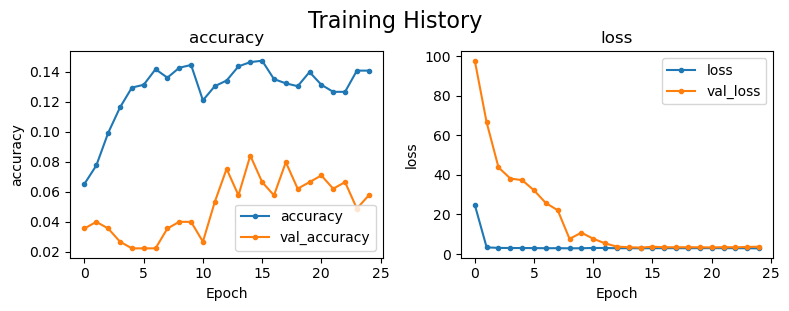


- Evaluating Test Data:
8/8 [==============================] - 0s 27ms/step - loss: 3.7130 - accuracy: 0.0658
{'loss': 3.712966203689575, 'accuracy': 0.06578947603702545} 

--------------------------------------------------------------------------------
 Classification Metrics: Test Data 
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           A       0.00      0.00      0.00         7
           B       0.00      0.00      0.00         5
           C       0.00      0.00      0.00         8
           D       0.00      0.00      0.00        12
           E       0.03      0.67      0.06         6
           F       0.00      0.00      0.00         7
           G       0.16      0.30      0.21        10
           H       0.00      0.00      0.00         5
           I       0.07      0.11      0.09         9
           J       0.00      0.00      0.00        16
           K       0.07      0.14

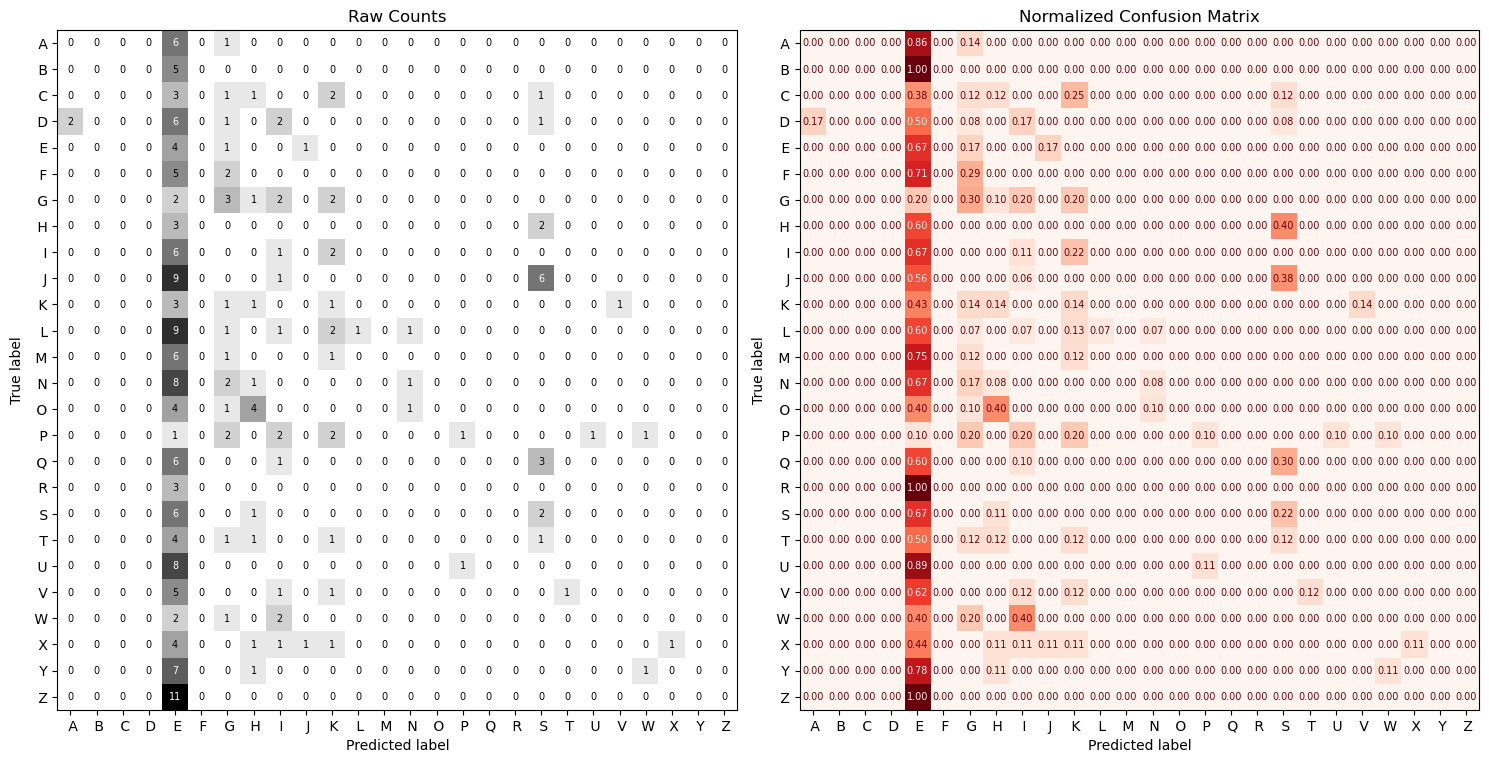


Overall Results:


precision    recall  f1-score  support  accuracy
macro avg   0.126298  0.069383  0.047158    228.0  0.065789

INFO:tensorflow:Assets written to: modeling/models/towards-data-science_lr-schedule/assets
- Model saved to modeling/models/towards-data-science_lr-schedule
- Classification Report saved to modeling/models/towards-data-science_lr-schedule/classification_report.txt
- History figure saved to modeling/models/towards-data-science_lr-schedule/history.png
- Confusion Matrix figure saved to modeling/models/towards-data-science_lr-schedule/confusion_matrix.png
CPU times: user 24.6 s, sys: 7.04 s, total: 31.7 s
Wall time: 1min 9s


In [63]:
%%time
# Baseline model
model = make_model(name='towards-data-science_lr-schedule', show_summary=False, 
                   use_schedule=True # Adding learning rate scheduling
                   )
model_results = fit_log_model(model, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, patience=PATIENCE,
                              save_results=True,model_directory=model_dir)

# history = model.fit(train_dataset,epochs = EPOCHS ,validation_data = val_dataset, callbacks=get_callbacks())

# results = custom_evaluate_classification_network(model,X_test=test_dataset,history=history, figsize=(15,15),
#                                                  target_names=label_lookup.values(),display_bar=True);


In [64]:
del model

## Model2 (Custom)

In [65]:

def make_model2(name='CNN1',show_summary=False,use_schedule=False):
    
    model = models.Sequential(name=name)
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1./255 , input_shape = (IMG_HEIGHT,IMG_WIDTH,3)))
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16,  # How many filters you want to use
            kernel_size=3, # size of each filter
            # input_shape=input_shape,
            padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling


    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=32,#64,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            # input_shape=input_shape,
            padding='same')) 
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(len(label_lookup), activation="softmax") )  
    
        
    ## JMI:
    if use_schedule:
        lr_schedule = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
        )  # 0.9)
        optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    else:
        optimizer = optimizers.legacy.Adam()#learning_rate=0.01)
    
    # ## Adding learning rate decay
    # lr_schedule = optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
    # )  # 0.9)
    # optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    if show_summary:
        model.summary()
    return model

Model: "cnn1-fixed-lr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 32768)           

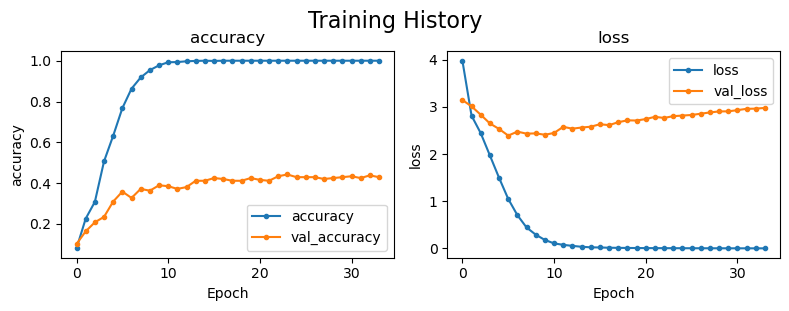


- Evaluating Test Data:
8/8 [==============================] - 0s 18ms/step - loss: 3.6809 - accuracy: 0.4167
{'loss': 3.6808974742889404, 'accuracy': 0.4166666567325592} 

--------------------------------------------------------------------------------
 Classification Metrics: Test Data 
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           A       0.17      0.29      0.21         7
           B       0.40      0.40      0.40         5
           C       0.40      0.25      0.31         8
           D       0.83      0.42      0.56        12
           E       0.14      0.33      0.20         6
           F       0.38      0.43      0.40         7
           G       0.75      0.60      0.67        10
           H       0.27      0.60      0.38         5
           I       0.50      0.67      0.57         9
           J       0.56      0.62      0.59        16
           K       0.67      0.57

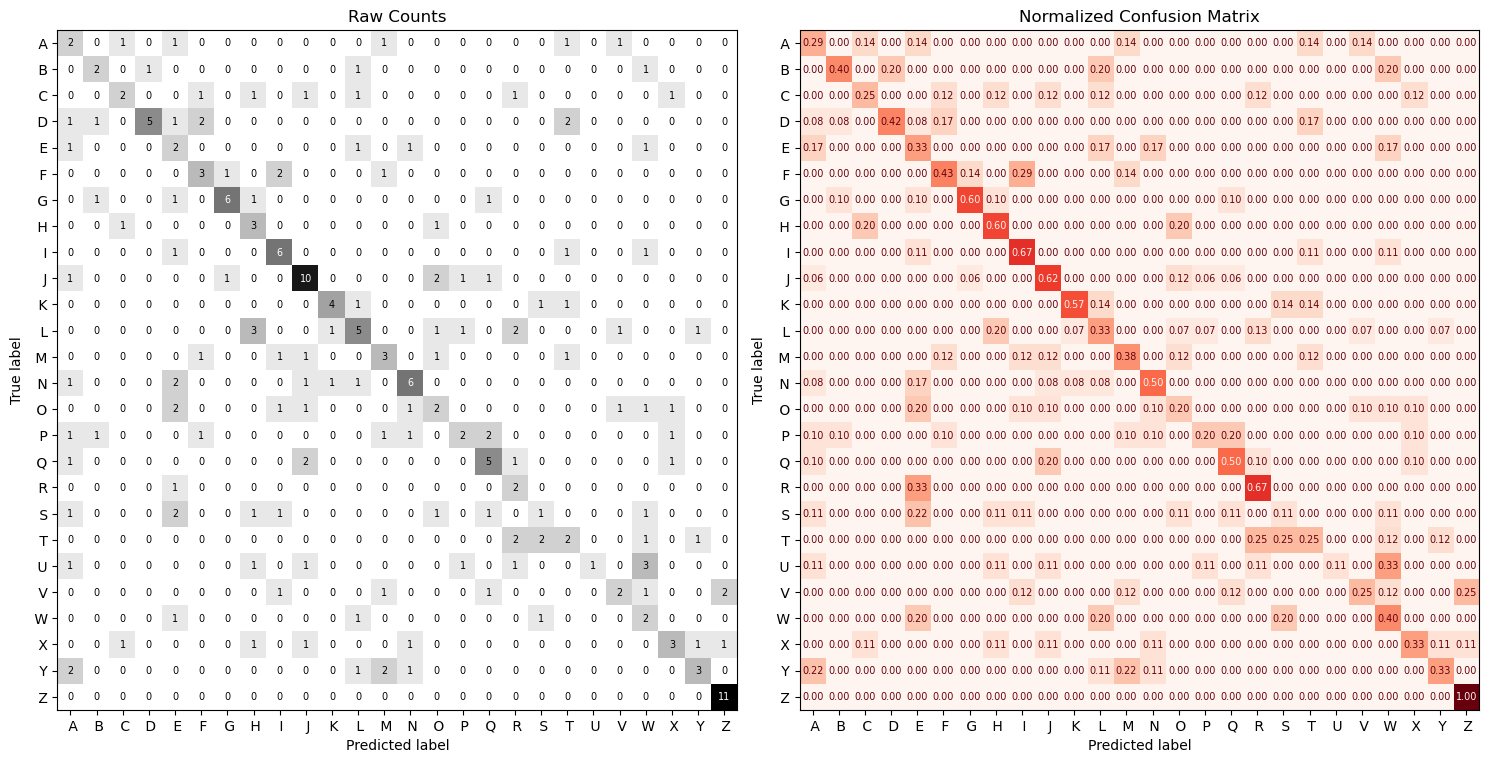


Overall Results:


precision    recall  f1-score  support  accuracy
macro avg   0.439076  0.413126  0.393261    228.0  0.416667

INFO:tensorflow:Assets written to: modeling/models/cnn1-fixed-lr/assets
- Model saved to modeling/models/cnn1-fixed-lr
- Classification Report saved to modeling/models/cnn1-fixed-lr/classification_report.txt
- History figure saved to modeling/models/cnn1-fixed-lr/history.png
- Confusion Matrix figure saved to modeling/models/cnn1-fixed-lr/confusion_matrix.png


In [66]:
## Show model architecture
model2 = make_model2(name="cnn1-fixed-lr", show_summary=True, use_schedule=False)
model2_results = fit_log_model(model2, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, patience=PATIENCE,
                              save_results=True,model_directory=model_dir)

### Adding LR Scheduling with Exponential Decay

Epoch 1/100
34/34 [==============================] - 1s 32ms/step - loss: 17.4408 - accuracy: 0.0624 - val_loss: 8.5287 - val_accuracy: 0.0398
Epoch 2/100
34/34 [==============================] - 1s 24ms/step - loss: 8.7243 - accuracy: 0.1115 - val_loss: 8.1355 - val_accuracy: 0.0487
Epoch 3/100
34/34 [==============================] - 1s 24ms/step - loss: 5.6390 - accuracy: 0.1900 - val_loss: 4.1000 - val_accuracy: 0.1018
Epoch 4/100
34/34 [==============================] - 1s 26ms/step - loss: 2.2842 - accuracy: 0.4357 - val_loss: 3.1407 - val_accuracy: 0.2478
Epoch 5/100
34/34 [==============================] - 1s 25ms/step - loss: 1.0637 - accuracy: 0.7212 - val_loss: 2.9139 - val_accuracy: 0.2832
Epoch 6/100
34/34 [==============================] - 1s 24ms/step - loss: 0.4966 - accuracy: 0.8904 - val_loss: 2.6241 - val_accuracy: 0.3363
Epoch 7/100
34/34 [==============================] - 1s 25ms/step - loss: 0.2400 - accuracy: 0.9565 - val_loss: 2.5646 - val_accuracy: 0.3894
Epoch

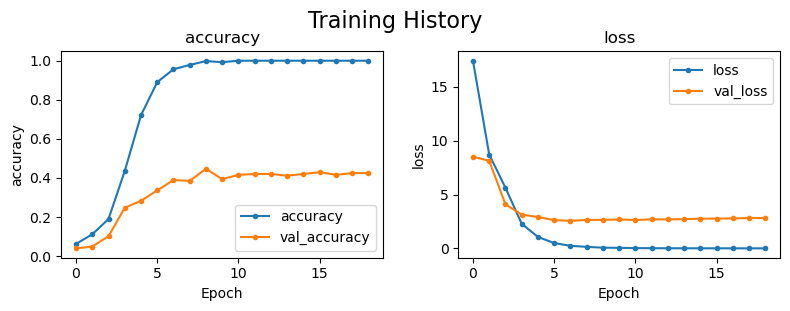


- Evaluating Test Data:
8/8 [==============================] - 0s 17ms/step - loss: 3.5362 - accuracy: 0.3904
{'loss': 3.536163330078125, 'accuracy': 0.390350878238678} 

--------------------------------------------------------------------------------
 Classification Metrics: Test Data 
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           A       0.20      0.43      0.27         7
           B       0.17      0.20      0.18         5
           C       0.50      0.38      0.43         8
           D       0.50      0.25      0.33        12
           E       0.15      0.33      0.21         6
           F       0.50      0.29      0.36         7
           G       0.55      0.60      0.57        10
           H       0.12      0.40      0.19         5
           I       0.36      0.56      0.43         9
           J       0.47      0.44      0.45        16
           K       0.62      0.71  

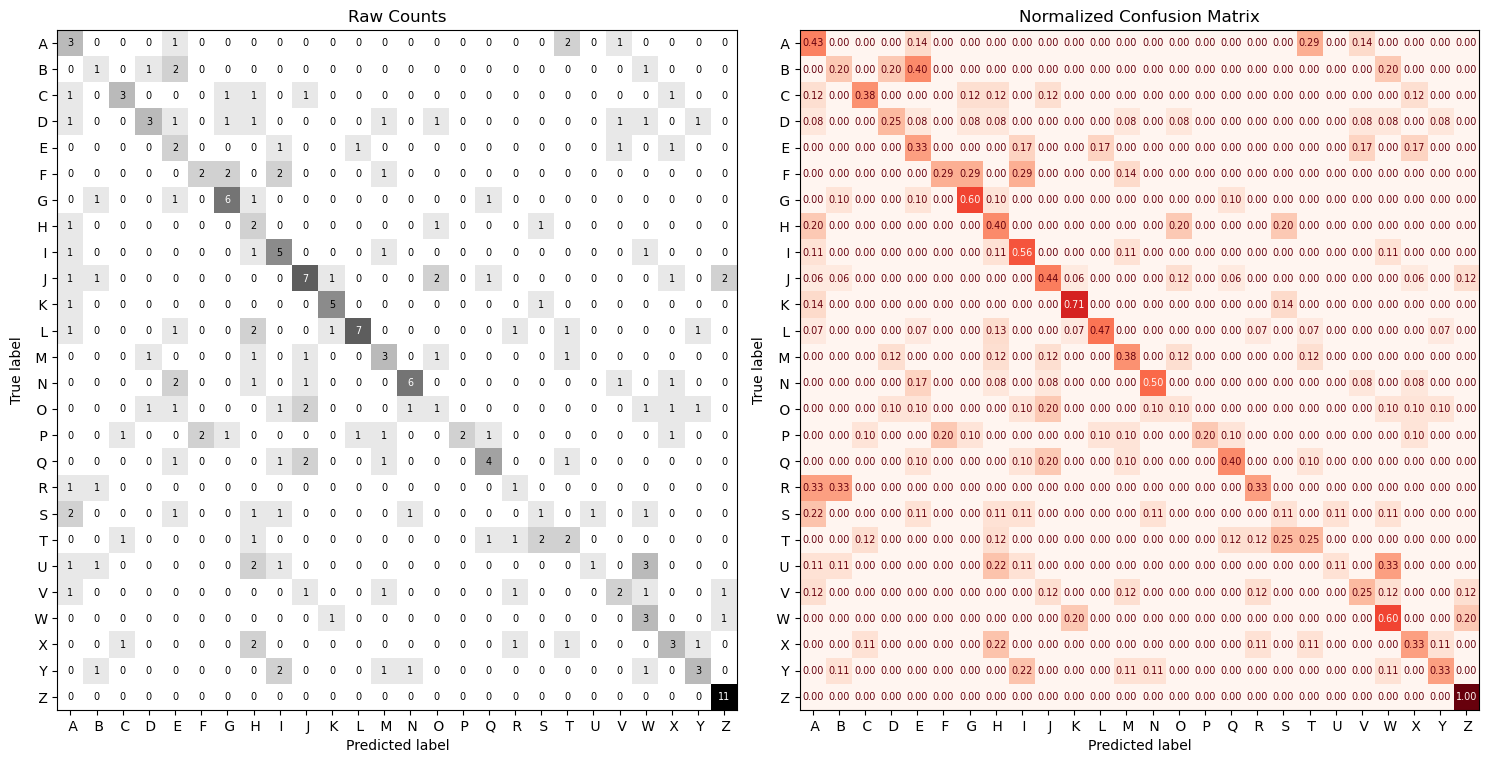


Overall Results:


precision    recall  f1-score  support  accuracy
macro avg   0.413855  0.382456  0.365179    228.0  0.390351

INFO:tensorflow:Assets written to: modeling/models/cnn1-scheduled-lr/assets
- Model saved to modeling/models/cnn1-scheduled-lr
- Classification Report saved to modeling/models/cnn1-scheduled-lr/classification_report.txt
- History figure saved to modeling/models/cnn1-scheduled-lr/history.png
- Confusion Matrix figure saved to modeling/models/cnn1-scheduled-lr/confusion_matrix.png
CPU times: user 16.1 s, sys: 4 s, total: 20.1 s
Wall time: 20.8 s


In [67]:
%%time
model2_lr = make_model2(use_schedule=True, show_summary=False, name="cnn1-scheduled-lr")
model2_lr_results = fit_log_model(model2_lr, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, patience=PATIENCE,
                              save_results=True,model_directory=model_dir)

del model2

## Transfer Learning



| Model             |   Size (MB) | Top-1 Accuracy   | Top-5 Accuracy   | Parameters   | Depth   | Time (ms) per inference step (CPU)   | Time (ms) per inference step (GPU)   |
|:------------------|------------:|:-----------------|:-----------------|:-------------|:--------|:-------------------------------------|:-------------------------------------|
| **VGG16**             |      528    | 71.3%            | 90.1%            | 138.4M       | 16      | 69.5                                 | 4.2                                  |
| **EfficientNetB0**    |       29    | 77.1%            | 93.3%            | 5.3M         | 132     | 46.0                                 | 4.9                                  |
| **InceptionV3**       |       92    | 77.9%            | 93.7%            | 23.9M        | 189     | 42.2                                 | 6.9                                  |

*Excerpt from Source: "https://keras.io/api/applications/"*

In [68]:
input_shape = (IMG_HEIGHT,IMG_WIDTH,3)
input_shape

(128, 128, 3)

### VGG16

In [69]:
# Downloading just the convolutional base
vgg16_base = tf.keras.applications.VGG16(
    include_top=False, weights="imagenet", input_shape=input_shape
)
# Prevent layers from base_model from changing 
vgg16_base.trainable = False

# Create the preprocessing lamdba layer
# Create a lambda layer for the preprocess input function for the model
lambda_layer_vgg16 = tf.keras.layers.Lambda(
    tf.keras.applications.vgg16.preprocess_input, name="preprocess_input"
)



def make_vgg16_model(name="VGG16",show_summary=False):
    model = models.Sequential(name=name)
    # Use input layer (lambda layer will handle rescaling).
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_vgg16)

    # Add pretrained base
    model.add(vgg16_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(label_lookup.values()), activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        # loss=tf.keras.losses.BinaryCrossentropy(),
        loss = tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    
    if show_summary:
        model.summary()
        
    return model


Epoch 1/100
34/34 [==============================] - 5s 120ms/step - loss: 13.4777 - accuracy: 0.1701 - val_loss: 2.6030 - val_accuracy: 0.2699
Epoch 2/100
34/34 [==============================] - 3s 97ms/step - loss: 1.8372 - accuracy: 0.4773 - val_loss: 2.4091 - val_accuracy: 0.3230
Epoch 3/100
34/34 [==============================] - 3s 96ms/step - loss: 1.1719 - accuracy: 0.6399 - val_loss: 2.3391 - val_accuracy: 0.3982
Epoch 4/100
34/34 [==============================] - 3s 98ms/step - loss: 0.8598 - accuracy: 0.7401 - val_loss: 2.1978 - val_accuracy: 0.4425
Epoch 5/100
34/34 [==============================] - 3s 98ms/step - loss: 0.6563 - accuracy: 0.7987 - val_loss: 2.3142 - val_accuracy: 0.4735
Epoch 6/100
34/34 [==============================] - 3s 96ms/step - loss: 0.4954 - accuracy: 0.8450 - val_loss: 2.1384 - val_accuracy: 0.4867
Epoch 7/100
34/34 [==============================] - 3s 98ms/step - loss: 0.4246 - accuracy: 0.8677 - val_loss: 2.1675 - val_accuracy: 0.5044
Epoc

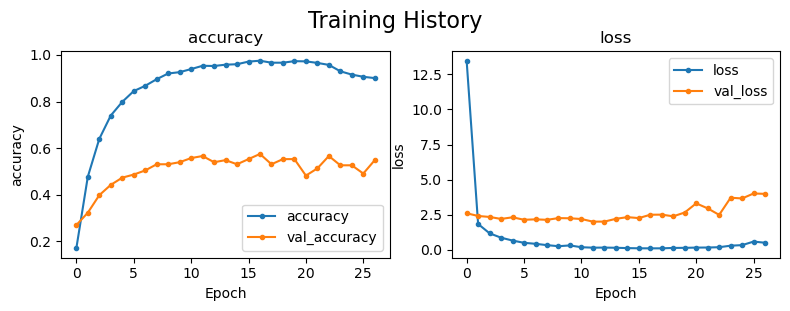


- Evaluating Test Data:
8/8 [==============================] - 1s 103ms/step - loss: 3.9852 - accuracy: 0.5132
{'loss': 3.985199451446533, 'accuracy': 0.5131579041481018} 

--------------------------------------------------------------------------------
 Classification Metrics: Test Data 
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           A       0.33      0.71      0.45         7
           B       0.50      0.20      0.29         5
           C       0.50      0.38      0.43         8
           D       0.33      0.25      0.29        12
           E       0.33      0.67      0.44         6
           F       0.50      0.43      0.46         7
           G       0.70      0.70      0.70        10
           H       0.38      0.60      0.46         5
           I       0.32      0.67      0.43         9
           J       0.59      0.81      0.68        16
           K       1.00      0.71

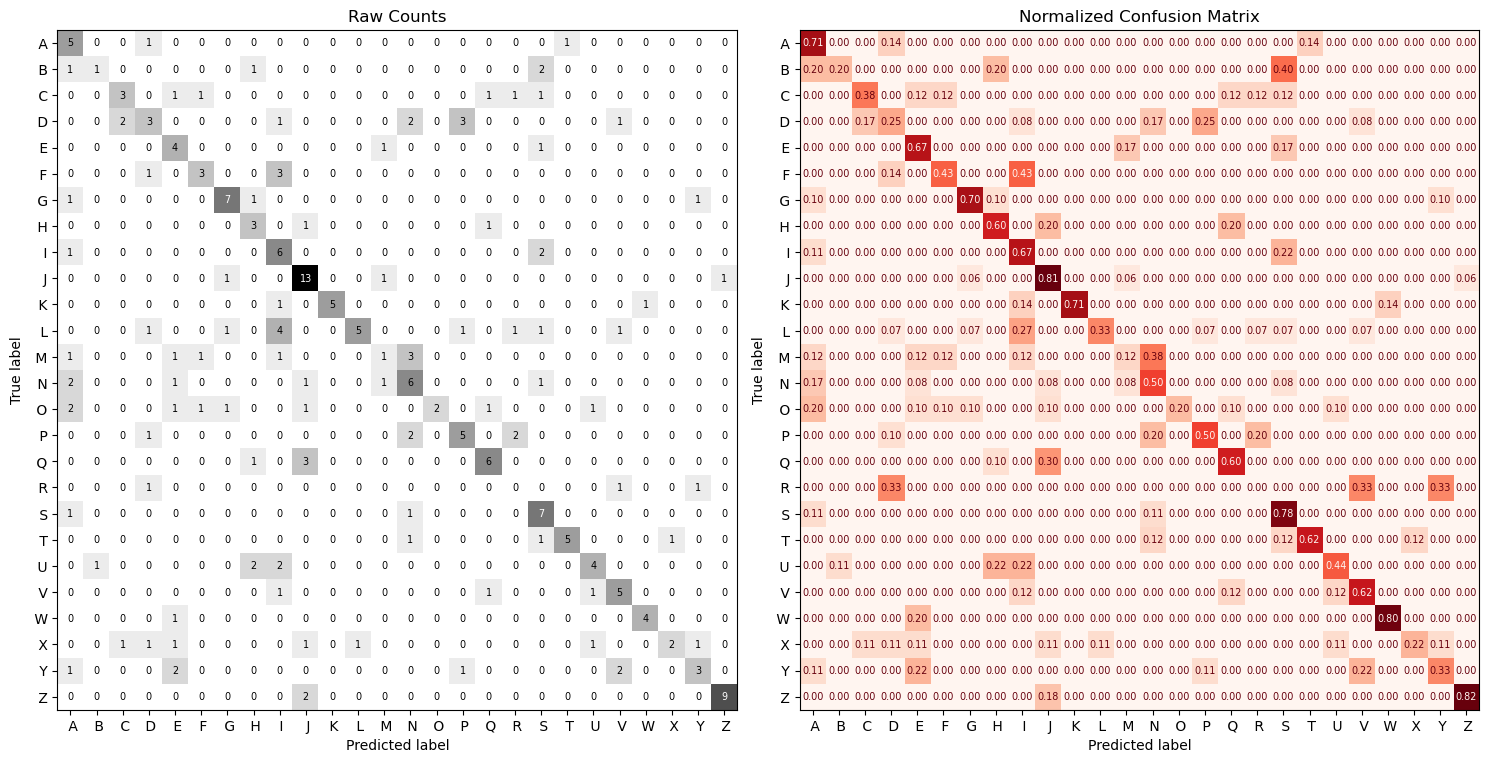


Overall Results:


precision    recall  f1-score  support  accuracy
macro avg   0.548998  0.501241  0.488813    228.0  0.513158

INFO:tensorflow:Assets written to: modeling/models/VGG16-01/assets
- Model saved to modeling/models/VGG16-01
- Classification Report saved to modeling/models/VGG16-01/classification_report.txt
- History figure saved to modeling/models/VGG16-01/history.png
- Confusion Matrix figure saved to modeling/models/VGG16-01/confusion_matrix.png
CPU times: user 27.8 s, sys: 13.2 s, total: 41.1 s
Wall time: 1min 39s


In [70]:
%%time
# Baseline model
model_vgg = make_vgg16_model(name="VGG16-01", show_summary=False)
model_vgg_results = fit_log_model(model_vgg, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, patience=PATIENCE,
                              save_results=True,model_directory=model_dir)
# history = model_vgg.fit(train_dataset,epochs = EPOCHS ,validation_data = val_dataset, callbacks=get_callbacks())

# results = custom_evaluate_classification_network(model_vgg,X_test=test_dataset,history=history, figsize=(15,15),
#                                                  target_names=label_lookup.values(),display_bar=True);


### EfficientNet

In [71]:
# Download EfficientNet base ## Changed to Netv2B0 to attempt to avoid error
efficientnet_base =tf.keras.applications.EfficientNetV2B0(include_top=False, 
                                                       input_shape=input_shape)
# efficientnet_base.summary()

In [72]:

# add preprocessing lambda layer
lambda_layer_efficient = tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, 
                                      name='preprocess_input_enet',)


def make_efficientnet_model(name="EfficientNetB0",show_summary=True, use_schedule=False):
    model = models.Sequential(name=name)
    # Use input layer (lambda layer will handle rescaling).
    
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_efficient)

    # Add pretrained base
    model.add(efficientnet_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(label_lookup.values()), activation="softmax"))

        ## JMI:
    if use_schedule:
        lr_schedule = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
        )  # 0.9)
        optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    else:
        optimizer = optimizers.legacy.Adam()#learning_rate=0.01)


    
    model.compile(
        optimizer=optimizer,#tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    
    if show_summary:
        model.summary()
    return model

# vk.layered_view(efficientnet_base, legend=True)

In [73]:
# model_eff = make_efficientnet_model(show_summary=True)

Epoch 1/100
34/34 [==============================] - 35s 538ms/step - loss: 2.5883 - accuracy: 0.3412 - val_loss: 1.3954 - val_accuracy: 0.6460
Epoch 2/100
34/34 [==============================] - 4s 132ms/step - loss: 0.2646 - accuracy: 0.9187 - val_loss: 1.0028 - val_accuracy: 0.6991
Epoch 3/100
34/34 [==============================] - 4s 127ms/step - loss: 0.0505 - accuracy: 0.9896 - val_loss: 0.9427 - val_accuracy: 0.7522
Epoch 4/100
34/34 [==============================] - 4s 120ms/step - loss: 0.0237 - accuracy: 0.9962 - val_loss: 0.8962 - val_accuracy: 0.7522
Epoch 5/100
34/34 [==============================] - 4s 121ms/step - loss: 0.0313 - accuracy: 0.9934 - val_loss: 0.8247 - val_accuracy: 0.7566
Epoch 6/100
34/34 [==============================] - 4s 118ms/step - loss: 0.0054 - accuracy: 0.9991 - val_loss: 0.9360 - val_accuracy: 0.7478
Epoch 7/100
34/34 [==============================] - 4s 117ms/step - loss: 0.0211 - accuracy: 0.9962 - val_loss: 0.8679 - val_accuracy: 0.765

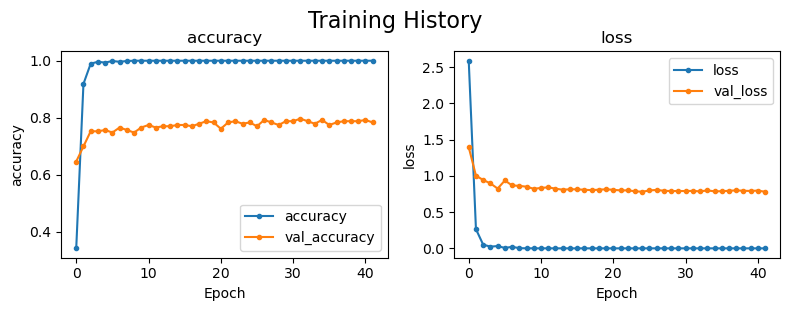


- Evaluating Test Data:
8/8 [==============================] - 4s 516ms/step - loss: 1.1142 - accuracy: 0.7368
{'loss': 1.1141910552978516, 'accuracy': 0.7368420958518982} 

--------------------------------------------------------------------------------
 Classification Metrics: Test Data 
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           A       0.67      0.86      0.75         7
           B       0.80      0.80      0.80         5
           C       1.00      0.88      0.93         8
           D       0.71      0.42      0.53        12
           E       0.56      0.83      0.67         6
           F       0.75      0.43      0.55         7
           G       0.78      0.70      0.74        10
           H       0.62      1.00      0.77         5
           I       0.50      0.78      0.61         9
           J       0.85      0.69      0.76        16
           K       0.86      0.8

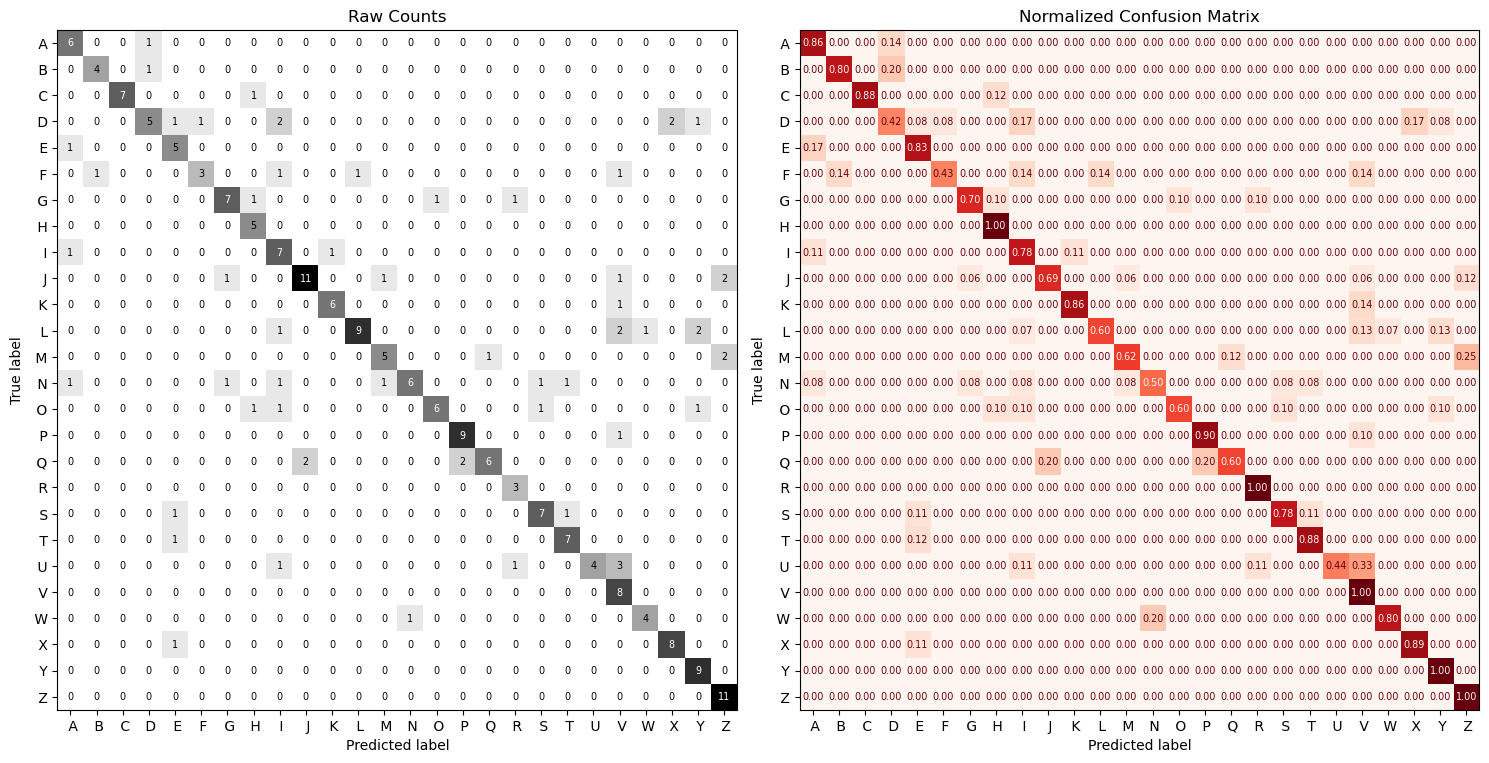


Overall Results:


precision   recall  f1-score  support  accuracy
macro avg   0.759549  0.76324  0.736638    228.0  0.736842

INFO:tensorflow:Assets written to: modeling/models/EfficientNetB0-1/assets
- Model saved to modeling/models/EfficientNetB0-1
- Classification Report saved to modeling/models/EfficientNetB0-1/classification_report.txt
- History figure saved to modeling/models/EfficientNetB0-1/history.png
- Confusion Matrix figure saved to modeling/models/EfficientNetB0-1/confusion_matrix.png
CPU times: user 3min 52s, sys: 38.4 s, total: 4min 30s
Wall time: 4min 3s


In [74]:
%%time
# Baseline model
model_eff = make_efficientnet_model(name="EfficientNetB0-1",show_summary=False, use_schedule=False)
model_eff_results = fit_log_model(model_eff, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, patience=PATIENCE,
                              save_results=True,model_directory=model_dir)


In [76]:
# raise Exception("Troubleshoot EfficientNet")

In [77]:
os.path.exists("modeling/models/EfficientNetB0-1/classification_report.txt")

True

In [78]:
logs_df= cf.logs.parse_log_file(log_file)
logs_df


[i] Saved parsed logs to modeling/nn_training.csv


Start Time                              Name  Precision  Recall  \
0  06/03/2024 16:56:18              towards-data-science      0.427   0.375   
1  06/03/2024 16:58:19  towards-data-science_lr-schedule      0.126   0.069   
2  06/03/2024 16:59:29                     cnn1-fixed-lr      0.439   0.413   
3  06/03/2024 17:00:03                 cnn1-scheduled-lr      0.414   0.382   
4  06/03/2024 17:00:24                          VGG16-01      0.549   0.501   
5  06/03/2024 17:02:06                  EfficientNetB0-1      0.760   0.763   

   F1-Score  Accuracy        Fit Time  \
0     0.352     0.390  0:01:51.209080   
1     0.047     0.066  0:01:04.811252   
2     0.393     0.417  0:00:28.916765   
3     0.365     0.390  0:00:16.496045   
4     0.489     0.513  0:01:31.155065   
5     0.737     0.737  0:03:24.025175   

                                   Model Save Fpath  
0              modeling/models/towards-data-science  
1  modeling/models/towards-data-science_lr-schedule  
2                     modeling/models/cnn1-fixed-lr  
3                 modeling/models/cnn1-scheduled-lr  
4                          modeling/models/VGG16-01  
5                  modeling/models/EfficientNetB0-1

In [79]:
results_df = logs_df.set_index("Model Save Fpath")
best_model_fpath = results_df['F1-Score'].idxmax()
best_model_fpath

'modeling/models/EfficientNetB0-1'

In [80]:
best_model_name = logs_df.set_index("Name")['F1-Score'].idxmax()
best_model_name

'EfficientNetB0-1'

In [81]:
best_model_fpath = logs_df.set_index("Model Save Fpath")['F1-Score'].idxmax()
best_model_fpath

'modeling/models/EfficientNetB0-1'

In [82]:
# loaded_model  =tf.keras.models.load_model(best_model_fpath)

dict_keys(['classification_report', 'history_fig', 'confusion_matrix_fig'])


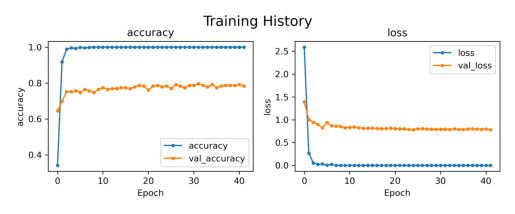

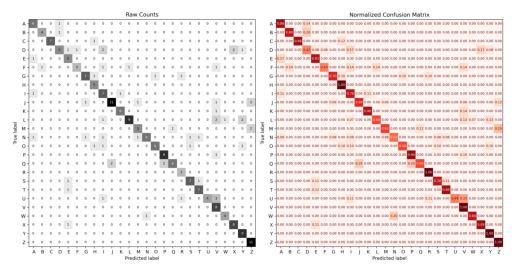

In [83]:

loaded = cf.logs.load_model_results(model_name=best_model_name,#logs_df.loc[0,'Name'],
                            model_directory= FPATHS['modeling']['model_dir'],
                            load_model=False # ISSUE WITH EFFICIENTNET
                            )
print(loaded.keys())
# loaded['model'].summary()

In [84]:
# model_eff.save(filepath=FPATHS['modeling']['best_transfer_fpaths']['model_dir'], save_format='tf')

## Keras Tuner - best model

In [207]:
import keras_tuner as kt
from keras_tuner import HyperParameters as hp
hp

keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters

In [ ]:
n_units = hp.Int('units', min_value=32, max_value=512, step=32)
dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)   

In [209]:

# add preprocessing lambda layer
lambda_layer_efficient = tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, 
                                      name='preprocess_input_enet',)


def tune_efficientnet_model(hp):
    name="EfficientNetB0" 
    input_shape = (IMG_HEIGHT,IMG_WIDTH,3)
    n_units = hp.Int('units', min_value=32, max_value=512, step=32)
    dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)   
    use_schedule = hp.Boolean('use_schedule')
    
    model = models.Sequential(name=name)
    # Use input layer (lambda layer will handle rescaling).
    
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_efficient)

    # Add pretrained base
    model.add(efficientnet_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(n_units, activation="relu"))
    model.add(layers.Dropout(dropout))

    # Output layer
    model.add(layers.Dense(len(label_lookup.values()), activation="softmax"))

        ## JMI:
    if use_schedule:
        lr_schedule = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
        )  # 0.9)
        optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    else:
        optimizer = optimizers.legacy.Adam()#learning_rate=0.01)


    
    model.compile(
        optimizer=optimizer,#tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    

    return model

# vk.layered_view(efficientnet_base, legend=True)

In [210]:
#hyperband allows for callbacks
tuner_hb = kt.Hyperband(tune_efficientnet_model, objective='val_accuracy',
                        max_epochs=20, overwrite=True)
tuner_hb.search_space_summary()


Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
use_schedule (Boolean)
{'default': False, 'conditions': []}


In [211]:
tuner_hb.search(train_dataset,validation_data=val_dataset,epochs=20)
                # callbacks=[tf.keras.callbacks.TensorBoard("/tmp/tb_logs")])
best_hp = tuner_hb.get_best_hyperparameters()[0]
print(best_hp)

Trial 9 Complete [00h 01m 40s]
val_accuracy: 0.03539822995662689

Best val_accuracy So Far: 0.17699114978313446
Total elapsed time: 00h 12m 39s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
448               |192               |units
0.3               |0.3               |dropout
True              |False             |use_schedule
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3
33/34 [============================>.] - ETA: 0s - loss: 23.2103 - accuracy: 0.0426

# Results

In [86]:
# raise Exception("Results work below moved to README maker notebook.")

## PREPARE TABLE FOR README

In [87]:

# logs_df = parse_log_file(log_file,clean_results=True      )
# readme_logs = logs_df.drop(columns=['Start Time'], errors='ignore')
# readme_logs = readme_logs.set_index('Name')
# readme_logs

In [88]:
# FPATHS['readme']['resul']

In [89]:
# results_md_file = FPATHS['readme']['results_table_md']
# readme_logs.to_markdown(results_md_file)


### To Do:  generate readme from results

In [90]:
# from IPython.display import Markdown
# with open(results_md_file) as f:
#     loaded_results = f.read()
# display(Markdown(loaded_results))
    

In [91]:
# readme_logs['duration'] = pd.to_timedelta(readme_logs['fit_time'],)

# readme_logs

# APPENDIX/WIP

## To Do: Keras Tuner

In [92]:
# ## Fit and evaluate model with custom function
# model2 = make_model2()
# history2 = model2.fit(train_dataset,epochs = 100 ,validation_data = val_dataset, callbacks=get_callbacks())
# results_dict = custom_evaluate_classification_network(model2,X_test=test_dataset,history=history2, figsize=(15,15), 
#                                                       target_names=label_lookup.values(),
#                                                       as_frame=True, frame_include_macro_avg=False, frame_include_support=False,
#                                                       display_bar=True)

In [93]:
# raise Exception("Do not run below yet.")

## To Do: Add LimeExplanations

In [94]:
BEST_MODEL = model_eff   #None

#### Convert test data to numpy arrays

In [95]:
%%time
# timing WITH converting classes
y_test, y_hat_test, X_test = cf.get_true_pred_labels_images(BEST_MODEL,test_dataset,
                                                         convert_y_for_sklearn=True)
y_test[0], y_hat_test[0]

CPU times: user 4.99 s, sys: 781 ms, total: 5.77 s
Wall time: 4.86 s


(3, 3)

In [96]:
label_lookup = {k:v.strip() for k,v in label_lookup.items()}

In [97]:
label_lookup

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z'}

In [98]:
i = 10
y_test[i]

10

## LimeExplainer

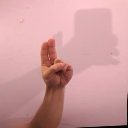

True Label: U
Predicted: U


In [106]:
# select an image index to use/view
i = 8

# Show actual-sized image with keras
display(array_to_img(X_test[i]))
print(f"True Label: {label_lookup[y_test[i]]}")
print(f"Predicted: {label_lookup[y_hat_test[i]]}")

### To Do:
- Fix the comparison images below 

In [107]:
from skimage.segmentation import mark_boundaries
from lime import lime_image

In [108]:
explainer = lime_image.LimeImageExplainer(verbose=True,random_state=321)
explainer

In [109]:
label= label_lookup[y_test[i]]
label

'U'

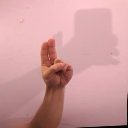

In [110]:
array_to_img(X_test[i])

In [113]:
# Get the explanation object for the chosen
explanation = explainer.explain_instance(X_test[i], # Convert image values to ints    
                                         BEST_MODEL.predict, # Prediction method/function
                                         top_labels=2, # How many of the labels to explain [?]
                                         hide_color=0, #
                                         num_samples=1000,
                                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step
Intercept -0.004871761408151695
Prediction_local [0.18326893]
Right: 0.14897422
Intercept -0.11035389858282549
Prediction_local [0.23901043]
Right: 0.6078114


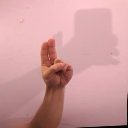

In [140]:
array_to_img(explanation.image)

In [141]:
explanation.image.max()

210.0

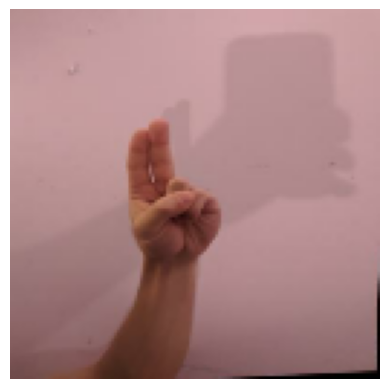

In [116]:
# Stored original image
plt.imshow(explanation.image.astype(int));
plt.axis('off');

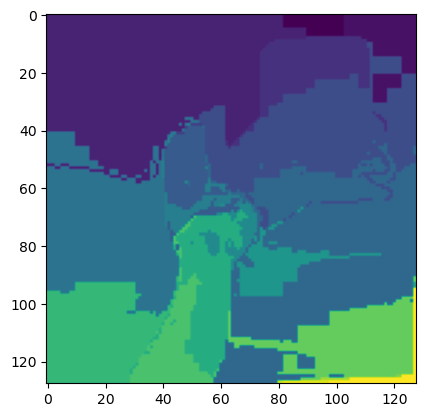

In [118]:
# Explanation split image into "segments"
plt.imshow(explanation.segments); 

In [119]:
# Unique Segments
len(np.unique(explanation.segments))

22

In [154]:
[label_lookup[k] for k in  explanation.top_labels]

['U', 'R']

In [156]:
label_lookup[y_test[i]]

'U'

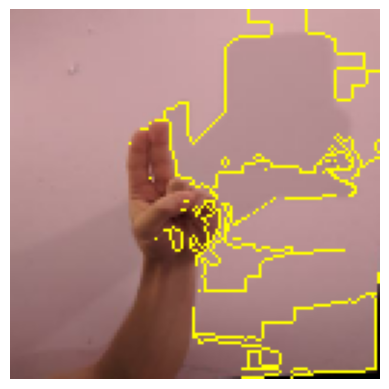

In [123]:
# Get the explanation for the top label
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Display the original image with the explanation
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.show()

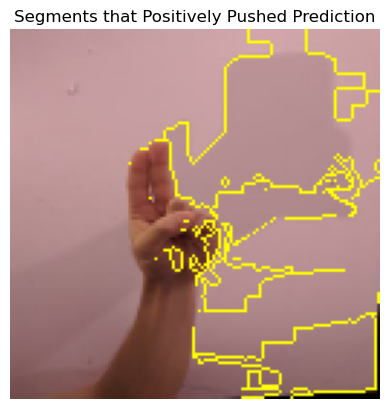

In [124]:
#pros and cons
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=10, 
                                            hide_rest=False
                                           )
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')
plt.title('Segments that Positively Pushed Prediction');

(-0.5, 127.5, 127.5, -0.5)

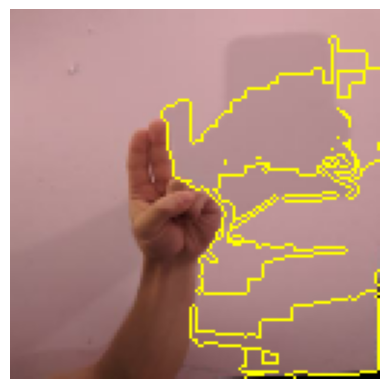

In [143]:
#pros and cons
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            negative_only=True, 
                                            positive_only=False,
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis('off')

In [144]:
temp.max() * 255

53550.0

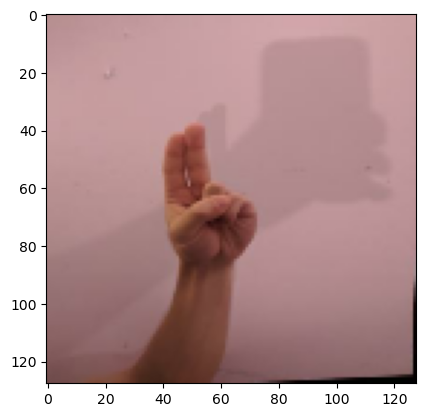

In [145]:
plt.imshow(temp/255.)

In [160]:
label_lookup

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z'}

In [166]:
# JMI AND CHRIS
pred_probs = BEST_MODEL.predict(X_test[i].reshape(1,IMG_HEIGHT,IMG_WIDTH,3))
pred_probs_dict = dict(zip(label_lookup.values(), pred_probs[0]))
pred_probs_df = pd.Series(pred_probs_dict).round(2).sort_values(ascending=False)
pred_probs_df


1/1 [==============================] - 0s 34ms/step


U    0.61
R    0.15
I    0.11
V    0.08
W    0.02
F    0.01
M    0.01
A    0.00
P    0.00
Y    0.00
X    0.00
T    0.00
S    0.00
Q    0.00
N    0.00
O    0.00
B    0.00
L    0.00
K    0.00
J    0.00
H    0.00
G    0.00
E    0.00
D    0.00
C    0.00
Z    0.00
dtype: float32

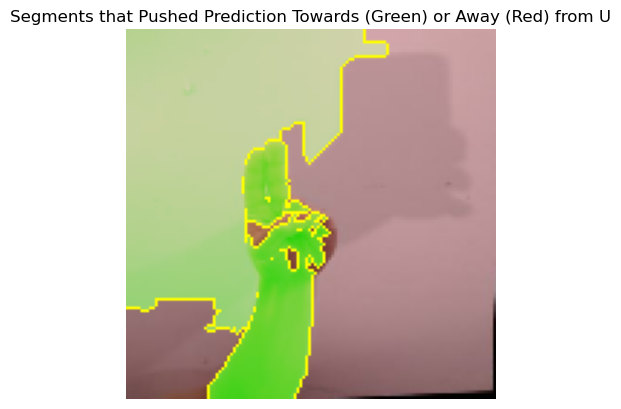

In [146]:
#pros and cons
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            negative_only=False, 
                                            positive_only=False,
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp/255.0, mask))
plt.axis('off')
plt.title(f'Segments that Pushed Prediction Towards (Green) or Away (Red) from {label}');

In [149]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

from IPython.display import clear_output

def plot_comparison(main_image, img, mask):
    """Adapted from Source:
    https://coderzcolumn.com/tutorials/artificial-intelligence/lime-explain-keras-image-classification-network-predictions"""
    fig,axes = plt.subplots(ncols=4,figsize=(15,5))

    img = img / 255.0
    # show original image
    ax = axes[0]
    ax.imshow(main_image.astype(int))#, cmap="gray");
    ax.set_title("Original Image")
    ax.axis('off')

    ax =axes[1]
    ax.imshow(img)#g.astype(int) )#.astype(int));
    ax.set_title("Image")
    ax.axis('off')
    
    ax = axes[2]
    ax.imshow(mask);
    ax.set_title("Mask")
    ax.axis('off')
    
    ax = axes[3]
    
    ax.imshow(mark_boundaries(img,
                              mask, color=(0,1,0)));
    ax.set_title("Image+Mask Combined");
    ax.axis('off')
    fig.tight_layout()
    

In [151]:
temp

array([[[180.       , 210.       , 142.       ],
        [181.00897  , 210.       , 143.00897  ],
        [182.27344  , 210.       , 144.27344  ],
        ...,
        [203.       , 161.       , 163.       ],
        [204.       , 162.       , 164.       ],
        [204.       , 162.       , 164.       ]],

       [[181.00897  , 210.       , 143.00897  ],
        [182.02692  , 210.       , 144.02692  ],
        [183.       , 210.       , 145.       ],
        ...,
        [202.       , 160.       , 162.       ],
        [203.       , 161.       , 163.       ],
        [203.       , 161.       , 163.       ]],

       [[182.27344  , 210.       , 144.27344  ],
        [183.       , 210.       , 145.       ],
        [183.60266  , 210.       , 145.60266  ],
        ...,
        [201.54688  , 159.54688  , 161.54688  ],
        [202.27344  , 160.27344  , 162.27344  ],
        [202.27344  , 160.27344  , 162.27344  ]],

       ...,

       [[112.328125 ,  76.328125 ,  76.328125 ],
        [11

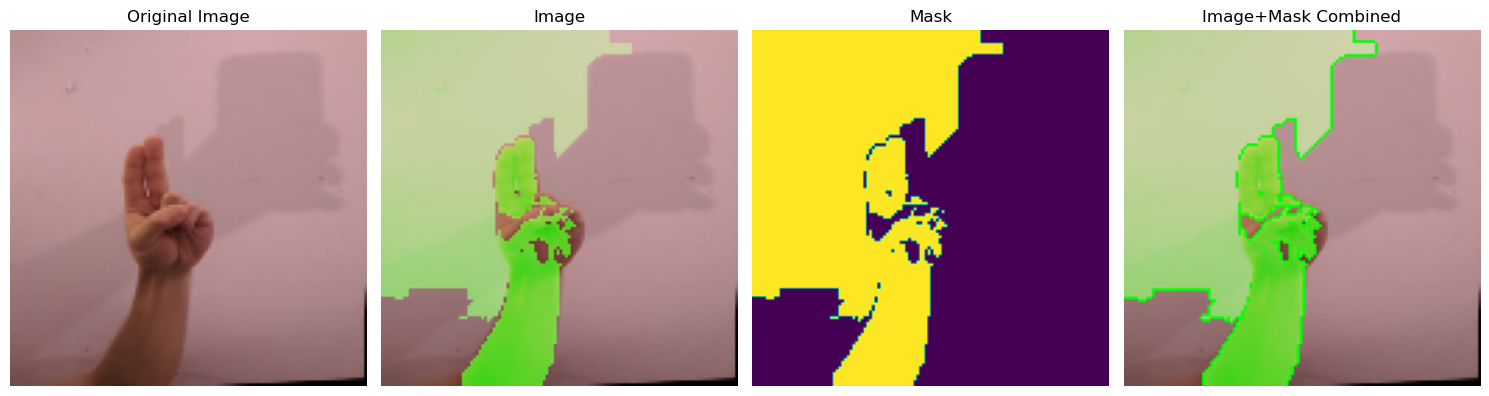

In [150]:
plot_comparison(X_test[i], temp, mask)

### Explaining an Incorrect Prediction

In [168]:


idx_incorrect =  y_hat_test != y_test
idx_incorrect

array([False, False,  True, False, False,  True, False,  True, False,
       False,  True, False, False, False, False, False, False,  True,
       False,  True, False, False, False,  True, False,  True,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False,  True,  True, False,  True, False, False, False,
       False, False,  True, False, False,  True,  True, False,  True,
       False, False,  True,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False,  True, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False,  True, False, False,  True, False,  True,
        True,  True,

In [172]:
X_test_wrong = X_test[idx_incorrect]
y_test_wrong = y_test[idx_incorrect]
y_hat_test_wrong = y_hat_test[idx_incorrect]

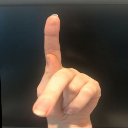

True Label: P
Predicted: U


In [173]:
# select an image index to use/view
i = 8

# Show actual-sized image with keras
display(array_to_img(X_test_wrong[i]))
print(f"True Label: {label_lookup[y_test_wrong[i]]}")
print(f"Predicted: {label_lookup[y_hat_test[i]]}")

In [175]:
# Get the explanation object for the chosen
explanation = explainer.explain_instance(X_test_wrong[i], # Convert image values to ints    
                                         BEST_MODEL.predict, # Prediction method/function
                                         top_labels=2, # How many of the labels to explain [?]
                                         hide_color=0, #
                                         num_samples=1000,
                                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step
Intercept 0.046997499190263026
Prediction_local [0.36332985]
Right: 0.27381897
Intercept 0.46413042280001926
Prediction_local [0.44096425]
Right: 0.6858508


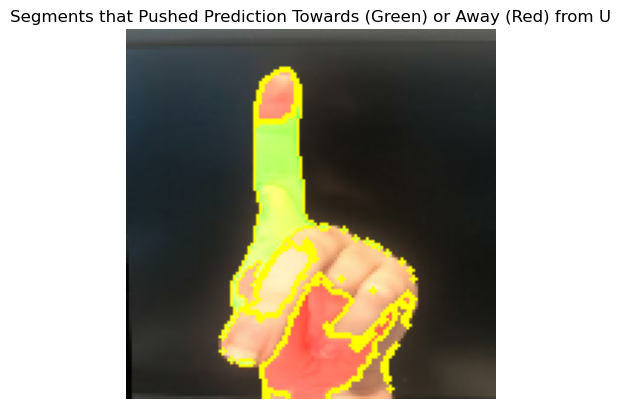

In [176]:
#pros and cons

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            negative_only=False, 
                                            positive_only=False,
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp/255.0, mask))
plt.axis('off')
plt.title(f'Segments that Pushed Prediction Towards (Green) or Away (Red) from {label}');

### Explaining Letters Often Confused

y_hat_test

In [177]:
confused_labels = ["U","V"]


In [180]:
label_index_lookup ={v:k for k,v in label_lookup.items()}
label_index_lookup

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25}

In [181]:
[label_index_lookup[l] for l in confused_labels]

[20, 21]

In [187]:
is_u = y_test == label_index_lookup['U']
pred_v = y_hat_test == label_index_lookup['V']

is_v = y_test == label_index_lookup['V']


In [189]:
idx_mistaken = is_u & pred_v
idx_mistaken

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False, False, False,
        True, False,

In [194]:
X_test_mistaken = X_test[idx_mistaken]
y_test_mistaken = y_test[idx_mistaken]
y_hat_test_mistaken = y_hat_test[idx_mistaken]
X_test_mistaken.shape

(3, 128, 128, 3)

In [193]:
# X_test_u = X_test[is_u]
# y_test_u = y_test[is_u]
# y_hat_test_u = y_hat_test[is_u]

# X_test_v = X_test[is_v]
# y_test_v = y_test[is_v]
# y_hat_test_v = y_hat_test[is_v]

True Label: U
Predicted: V


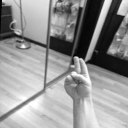

In [195]:
i = 0


print(f"True Label: {label_lookup[y_test_mistaken[i]]}")
print(f"Predicted: {label_lookup[y_hat_test_mistaken[i]]}")
display(array_to_img(X_test_mistaken[i]))

In [196]:
# Get the explanation object for the chosen
explanation = explainer.explain_instance(X_test_mistaken[i], # Convert image values to ints    
                                         BEST_MODEL.predict, # Prediction method/function
                                         top_labels=2, # How many of the labels to explain [?]
                                         hide_color=0, #
                                         num_samples=1000,
                                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step
Intercept 0.07957485930686162
Prediction_local [0.16606174]
Right: 0.08305036
Intercept 0.1119824807239807
Prediction_local [0.60833465]
Right: 0.8092748


In [203]:
# label_index_lookup

In [204]:
[label_lookup[l] for l in explanation.top_labels]

['V', 'U']

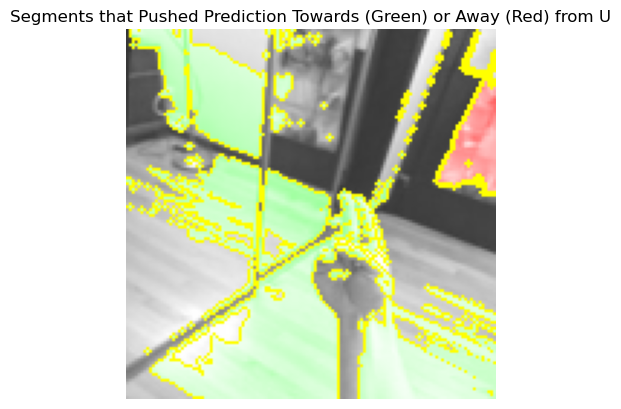

In [197]:
#pros and cons

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            negative_only=False, 
                                            positive_only=False,
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp/255.0, mask))
plt.axis('off')
plt.title(f'Segments that Pushed Prediction Towards (Green) or Away (Red) from {label}');